In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gwparents
from astropy.cosmology import Planck15
import icarogw
import bilby
import corner

# Functionality of gwparents

In this notebook we show some of the classes and methods of gwparents.

## Rapresenting syntehtic populations: 

Synthetic populations are hosted in the `synthethic_population` class that can be used to perform several taks.

### Example with a trivial population

We will show how the code works using two populations that does not overlap at all in the parameter space. We generate two populations in two variables, `x` and `y`. `Model_0` will be distribuited between 0 and 1 uniformly, while `Model_1` will be distribuited between -1 and 0 uniformly. We also apply a selection cut according to which all the `x<=0.9` are detected.


In [3]:
# Number of bins used to build the histograms of the population
bins={'x':40,'y':40}

# Defines the dictionary for a population in mass_1_source, mass_2_source and redshift distribuited uniform
popbin={'x':{'values':np.random.rand(10000),'tex_label':r'$x$','tex_var':r'x'},
        'y': {'values':np.random.rand(10000),'tex_label':r'$y$','tex_var':r'y'},
       }

# Define the population called model_0, here we will assume that the total number of binaries produced by this model is 1e6
# The prior_to_rem is only used when interacting with posteriors from real event
# We will set a prior on the model 1 (it is normalized later)
pop_1=gwparents.synthetic_population.synthetic_population('model_0',1e6,popbin,prior_to_rem=np.ones(10000),prior_model=1.,Tobs=1.)

# Select all the binaries with detected mass lower than 0.5
idx_det=pop_1.binary_params['x']['values']<=0.5
# Apply the selection cut
pop_1.apply_selection_cut(ilabel_det=idx_det)

# Defines the second population
popbin={'x':{'values':np.random.rand(10000)-1,'tex_label':r'$x$','tex_var':r'x'},
        'y': {'values':np.random.rand(10000)-1,'tex_label':r'$y$','tex_var':r'y'},
       }


# Same as above initializing the second population and its selection cut
pop_2=gwparents.synthetic_population.synthetic_population('model_1',1e6,popbin,prior_to_rem=np.ones(10000),prior_model=1.,Tobs=1.)
idx_det=pop_2.binary_params['x']['values']<=0.5
pop_2.apply_selection_cut(ilabel_det=idx_det)

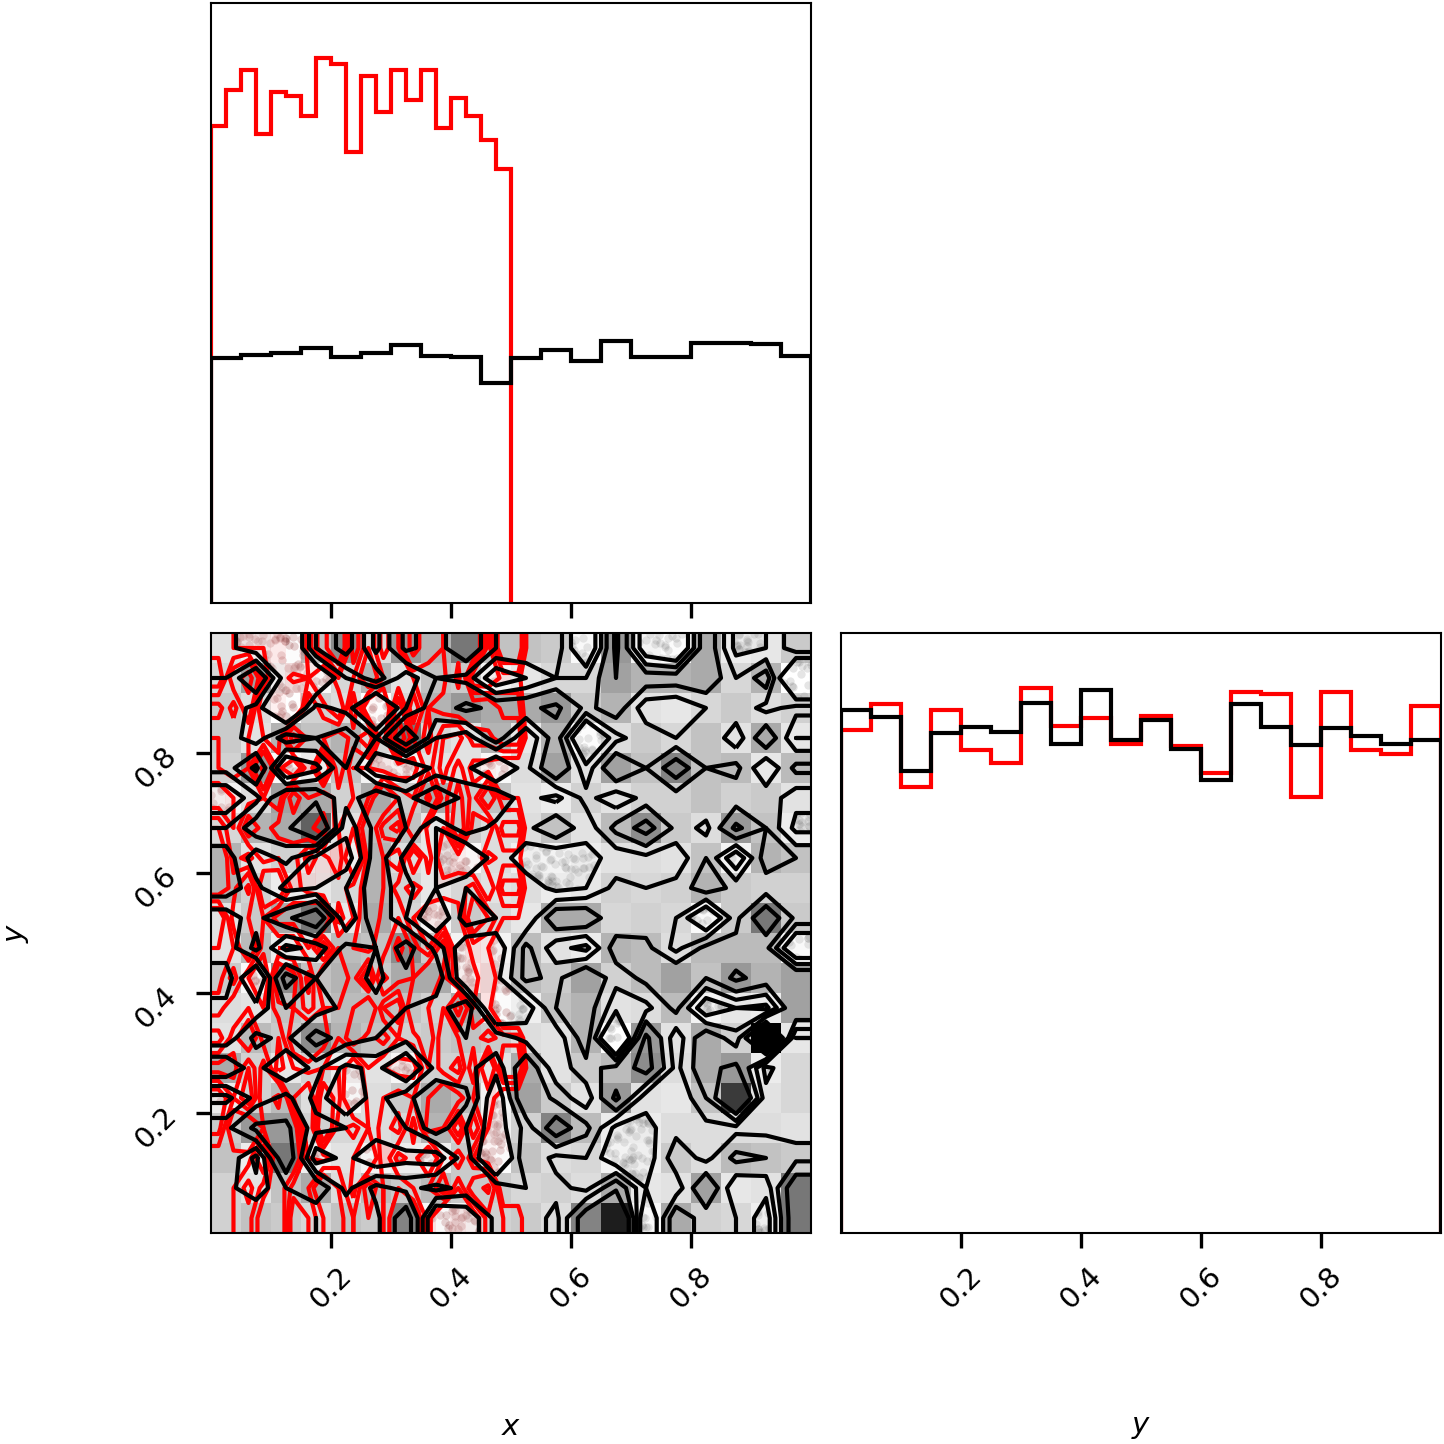

In [4]:
# We show histograms of the astrophysical (black) and detected (red) population for model_0
fig=pop_1.histogram_detected_population(hist_kwargs={'density':True},color='red')
fig=pop_1.histogram_astrophysical_population(fig=fig,hist_kwargs={'density':True})

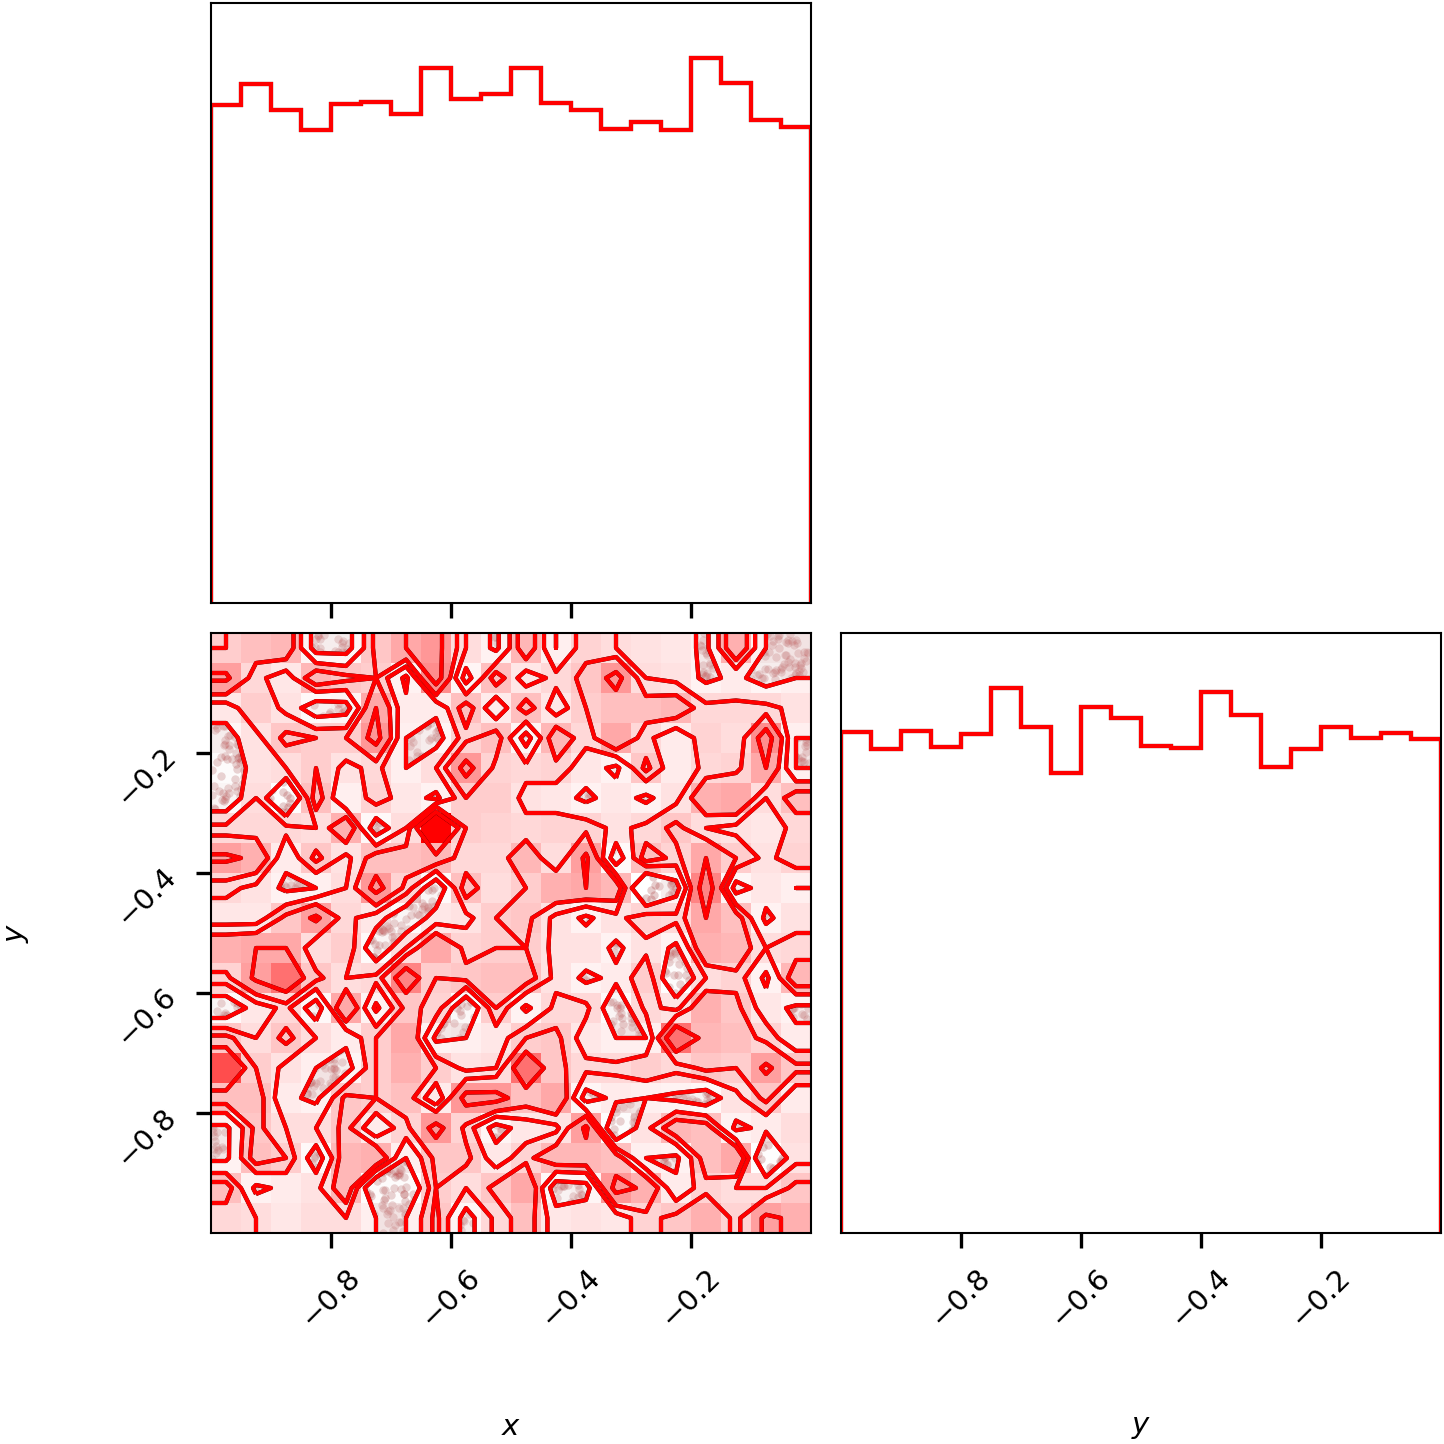

In [5]:
# We show histograms of the astrophysical (black) and detected (red) population for model_0
fig=pop_2.histogram_astrophysical_population(hist_kwargs={'density':True})
fig=pop_2.histogram_detected_population(fig=fig,hist_kwargs={'density':True},color='red')

In [6]:
# We can also define a list of populations. You can use the list of population to perform several actions related to multi-channel analysis 
listofpop=gwparents.synthetic_population.list_of_populations([pop_1,pop_2])

In [7]:
# We now calculate the probability of any given model given a set of parameters
# This will also initialize a common grid among all the simulations.
# We pass the bins to caclulate the grid
listofpop.calculate_log_pmodel_given_theta({'x':20,'y':20})

/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)


/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)
/home/smastro/git_repositor

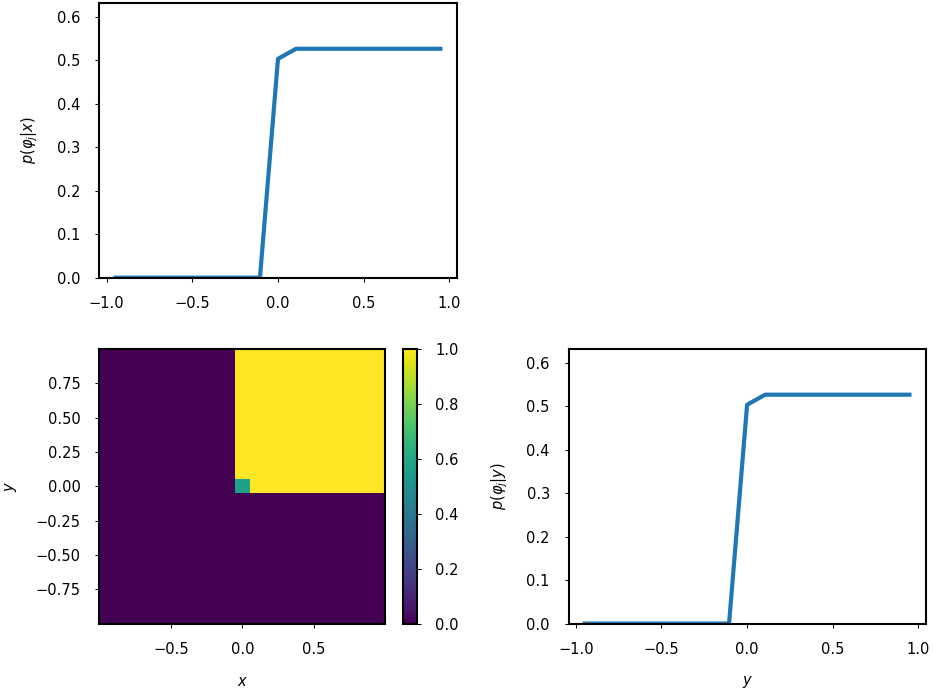

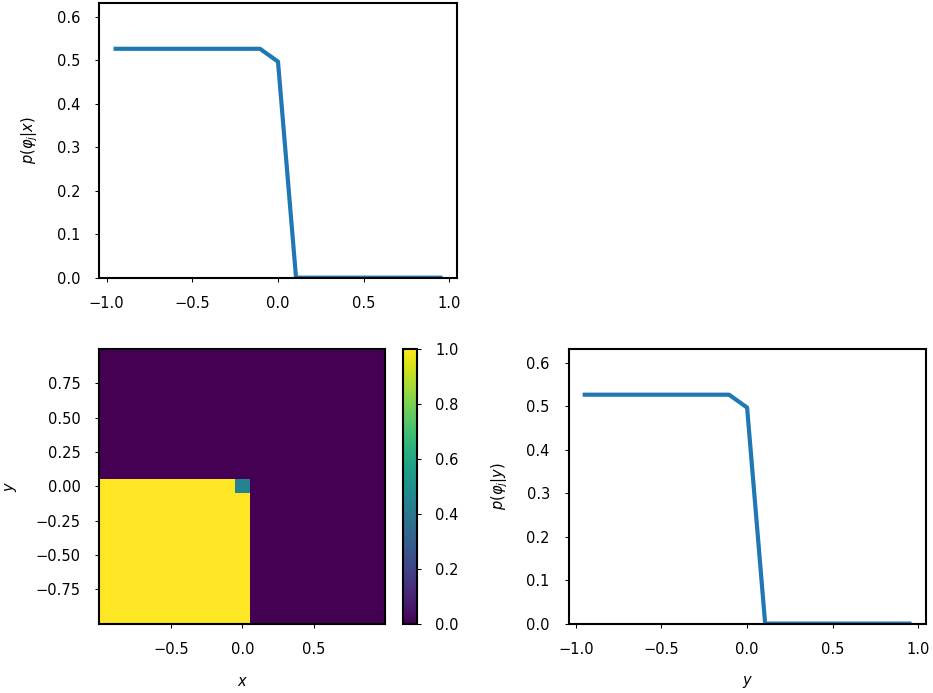

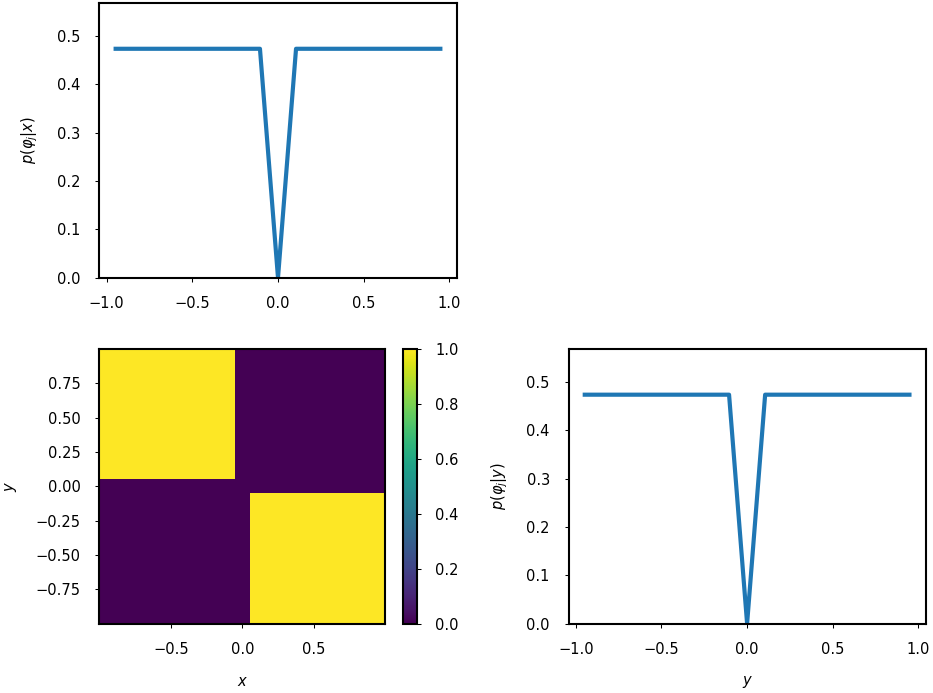

In [8]:
# We can also decide to plot the corner plots of p(phi|variables) to check if we like the binning
# You can clearly see the meaning of p(phi|variables), when we are in a point of the parameter space
# Supported just by one population, the p(phi|variables) is one. Note that we also define the null probability
# i.e. that region in the parameter space does not have support in any of the models
fig=listofpop.plot_pmodel_given_theta('model_0',bins={'x':20,'y':20})
fig=listofpop.plot_pmodel_given_theta('model_1',bins={'x':20,'y':20})
fig=listofpop.plot_pmodel_given_theta('null',bins={'x':20,'y':20})

### Calculating the overlap

Given an inferred phenomenological population, we can compute the overlap of a model as 

$$ p(\varphi_j|\{x\})=\int d\Lambda p(\Lambda|\{x\}) \int d\theta p(N_{\rm exp}|\Lambda)p(\theta|\Lambda)p(\varphi|N_{\rm exp}(\Lambda),\theta)$$

In [9]:
# Let us assume that we have managed to get the correct population and that the correct model is model_0
# from phenomenological models, we generate samples from it
phenom_dict_1={'x':np.random.rand(10000),
               'y':np.random.rand(10000)}
listofpop.calculate_phehom_match([phenom_dict_1],bins={'x':20,'y':20})

# You can see that the probability of model_0 is very high.

/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)


{'model_0': 0.9986750000000008,
 'model_1': 0.0012250000000000013,
 'null': 9.999999999921183e-05}

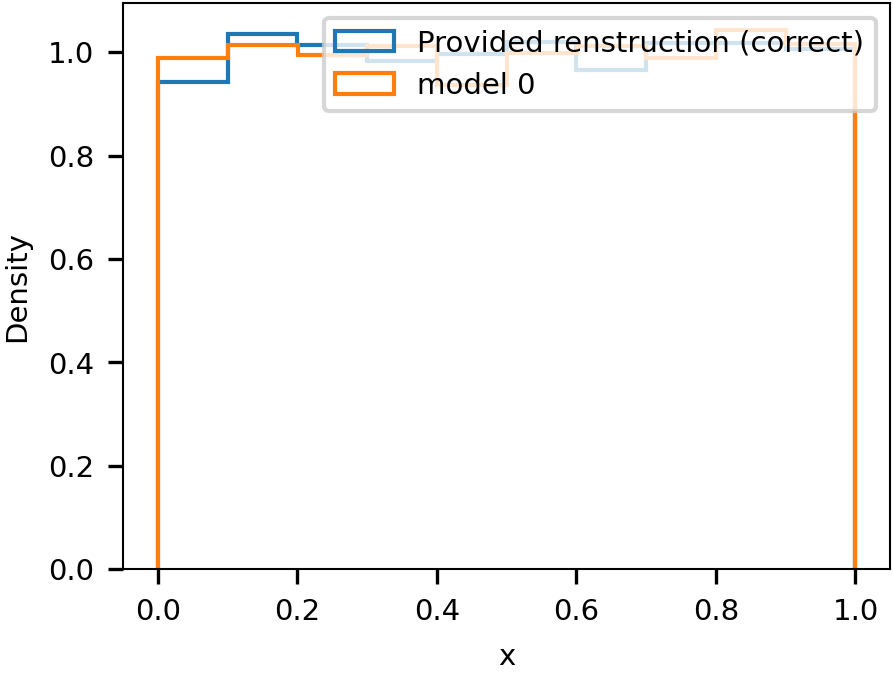

In [10]:
plt.hist(phenom_dict_1['x'],density=True,histtype='step',label='Provided renstruction (correct)')
plt.hist(listofpop.population_list['model_0'].binary_params['x']['values'],density=True,histtype='step',label='model 0')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

Another way in which you can interpret the probabilities is the following: The ratio of two p(varphi_j) is basically how much more model_0 overlaps to the phenom population w.r.t. model_1

In [11]:
# Now we generate a population which is in the middle of model_0 and model_1, basically 1/4 and 1/4 in model_0 and
# model_1 and the rest in the null hypothesis
phenom_dict_1={'x':np.random.rand(10000)-0.5,
               'y':np.random.rand(10000)-0.5}
listofpop.calculate_phehom_match([phenom_dict_1],bins={'x':50,'y':50})

# You can see that more or less 30% and 30% is in model _0 and model_1 and the rest is in null. 
# There is a bit of overlap given the discritized binning (you can reduce it decreasing the binning size)
# You can see that the null contains more or less 2 times the binaries that contains model_0 and model_1

/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)


{'model_0': 0.27150000000000024,
 'model_1': 0.27460000000000023,
 'null': 0.4538999999999995}

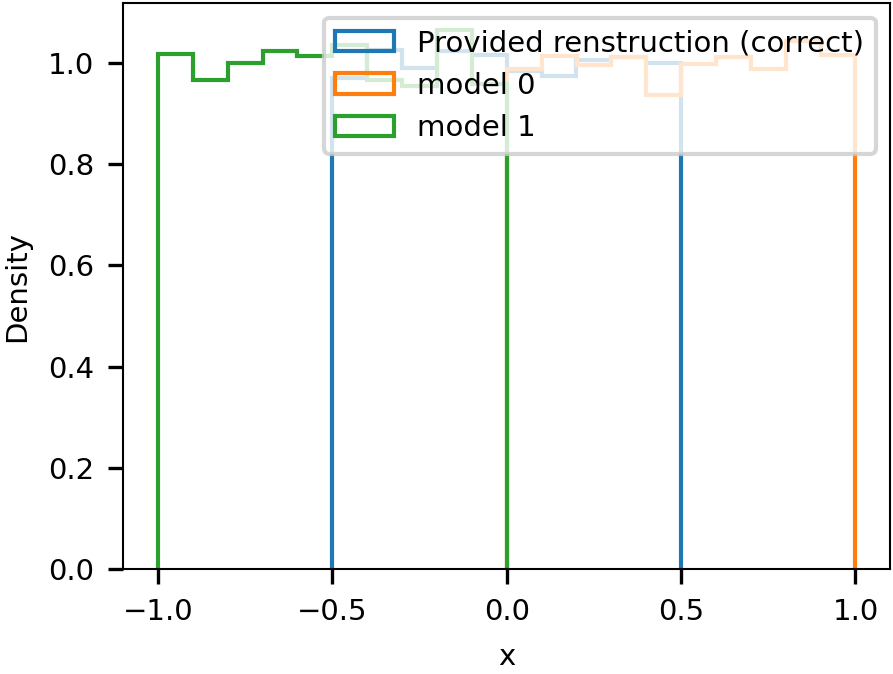

In [12]:
plt.hist(phenom_dict_1['x'],density=True,histtype='step',label='Provided renstruction (correct)')
plt.hist(listofpop.population_list['model_0'].binary_params['x']['values'],density=True,histtype='step',label='model 0')
plt.hist(listofpop.population_list['model_1'].binary_params['x']['values'],density=True,histtype='step',label='model 1')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

## A GW example

Let us now perform the computation above with a more concrete GW example. We will generate three populations in source masses and redshift. We will make use of [icarogw](https://pypi.org/project/icarogw/) to quickly generage posterior samples. We will assume that the second model produces half of the BBHs produced by the first model

In [13]:
import icarogw

bins={'mass_1_source':40,'mass_2_source':40}
m1fin=[]
m2fin=[]

# We draw 100000 mass samples from the frist mass model
mp1=icarogw.priors.mass.mass_prior('BBH-powerlaw',{'alpha':2.0,'beta':1.,'mmin':5,'mmax':50.})
Ntot1=100000
m1,m2=mp1.sample(Ntot1)
m1fin.append(m1)
m2fin.append(m2)

popbin={'mass_1_source':{'values':m1,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
       }

# Initialize the first population
pop_1=gwparents.synthetic_population.synthetic_population('model_0',Ntot1,popbin,prior_to_rem=np.ones(Ntot1),prior_model=1.,Tobs=1.)

# We draw 500000 mass samples from the second mass model
mp1=icarogw.priors.mass.mass_prior('BBH-powerlaw',{'alpha':0.,'beta':0.,'mmin':20,'mmax':90.})
Ntot2=50000
m1,m2=mp1.sample(Ntot2)
m1fin.append(m1)
m2fin.append(m2)

popbin={'mass_1_source':{'values':m1,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
       }

# Same as above initializing the second population and its selection cut
pop_2=gwparents.synthetic_population.synthetic_population('model_1',Ntot2,popbin,prior_to_rem=np.ones(Ntot2),prior_model=1.,Tobs=1.)

popbin={'mass_1_source':{'values':np.hstack(m1fin),'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':np.hstack(m2fin),'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
       }

# Same as above initializing the second population and its selection cut
pop_fin=gwparents.synthetic_population.synthetic_population('True',Ntot1+Ntot2,popbin,prior_to_rem=np.ones(len(m1fin)),prior_model=1.,Tobs=1.)




Below we will plot the populations that we have simulated. We also define a reconstruction of the population by a phenomenological model. We assume that the phenomenological model has been able to reconstruct the population with a 10% accuracy.

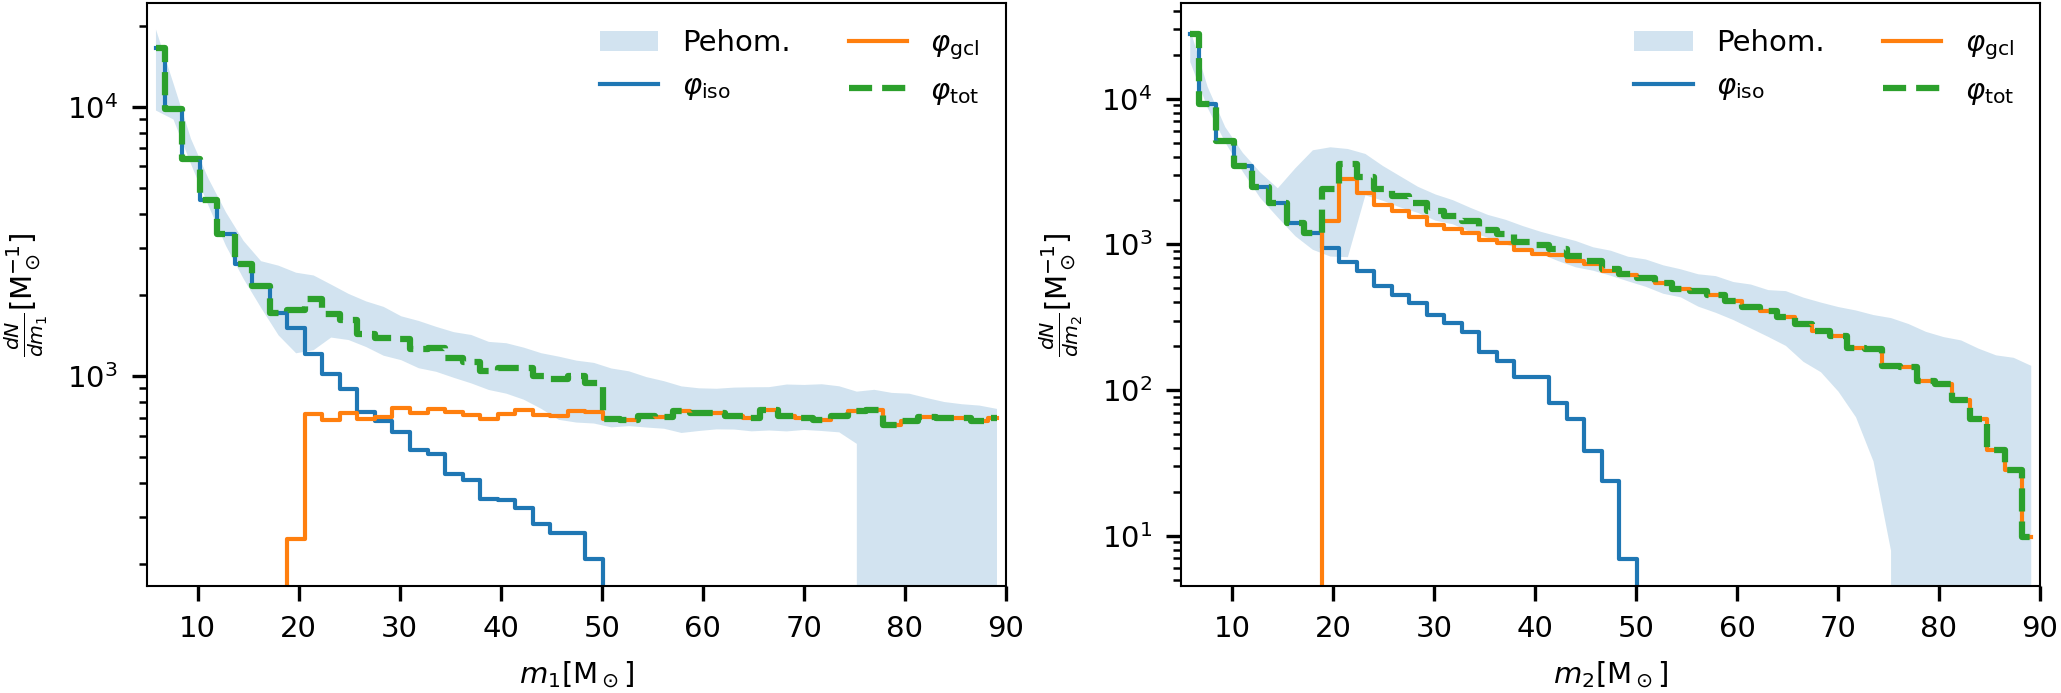

In [14]:
fig,ax=plt.subplots(1,2,figsize=(7.0,2.5))
bins=np.linspace(5,90,50)

Nsuc=100
err1=np.zeros([Nsuc,50-1])
err2=np.zeros([Nsuc,50-1])

pop_reco_list=[]
Nreco=[]
for i in range(Nsuc):
    
    m1fin=[]
    m2fin=[]

    mp1=icarogw.priors.mass.mass_prior('BBH-powerlaw',{'alpha':2.0*(1-np.random.randn()*0.1),
                                                       'beta':1*(1-np.random.randn()*0.1),
                                                       'mmin':5*(1-np.random.randn()*0.1),
                                                       'mmax':50*(1-np.random.randn()*0.1)})
    Nerr=(1-np.random.randn()*0.1)
    Nerr=1
    Ntot1=int(100000*Nerr)
    m1,m2=mp1.sample(Ntot1)
    m1fin.append(m1)
    m2fin.append(m2)

    mp1=icarogw.priors.mass.mass_prior('BBH-powerlaw',{'alpha':np.random.randn()*0.1,
                                                       'beta':np.random.randn()*0.1,
                                                       'mmin':20.*(1-np.random.randn()*0.1),
                                                       'mmax':90.*(1-np.random.randn()*0.1)})
    Ntot2=int(50000*Nerr)
    m1,m2=mp1.sample(Ntot2)
    m1fin.append(m1)
    m2fin.append(m2)
                                                       
    m1fin=np.hstack(m1fin)
    m2fin=np.hstack(m2fin)
    counts,edges=np.histogram(m1fin,bins=bins,density=True)
    err1[i,:]=counts*(Ntot1+Ntot2)
    counts,edges=np.histogram(m2fin,bins=bins,density=True)
    err2[i,:]=counts*(Ntot1+Ntot2)
    
    pop_reco_list.append({'mass_1_source':m1fin,'mass_2_source':m2fin})
    Nreco.append(Ntot1+Ntot2)
    
ax[0].fill_between(0.5*(edges[:-1:]+edges[1::]),np.percentile(err1,5,axis=0),np.percentile(err1,95,axis=0),alpha=0.2,label='Pehom.')                                                       
ax[1].fill_between(0.5*(edges[:-1:]+edges[1::]),np.percentile(err2,5,axis=0),np.percentile(err2,95,axis=0),alpha=0.2,label='Pehom.')                                                       

counts,edges=np.histogram(pop_1.binary_params['mass_1_source']['values'],bins=bins,density=True)
ax[0].step(0.5*(edges[:-1:]+edges[1::]),counts*10000*10,label=r'$\varphi_{\rm iso}$',where='mid',linewidth=1.)

counts,edges=np.histogram(pop_2.binary_params['mass_1_source']['values'],bins=bins,density=True)
ax[0].step(0.5*(edges[:-1:]+edges[1::]),counts*5000*10,label=r'$\varphi_{\rm gcl}$',where='mid',linewidth=1.)

counts,edges=np.histogram(pop_fin.binary_params['mass_1_source']['values'],bins=bins,density=True)
ax[0].step(0.5*(edges[:-1:]+edges[1::]),counts*(15000*10),label=r'$\varphi_{\rm tot}$',ls='--',where='mid',linewidth=1.5)

ax[0].legend(ncol=2,frameon=False)
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\frac{dN}{dm_1} {\rm [M^{-1}_\odot]}$')
ax[0].set_xlabel(r'$m_1 {\rm [M_\odot]}$')
ax[0].set_xlim([5,90])


counts,edges=np.histogram(pop_1.binary_params['mass_2_source']['values'],bins=bins,density=True)
ax[1].step(0.5*(edges[:-1:]+edges[1::]),counts*100000,label=r'$\varphi_{\rm iso}$',where='mid')

counts,edges=np.histogram(pop_2.binary_params['mass_2_source']['values'],bins=bins,density=True)
ax[1].step(0.5*(edges[:-1:]+edges[1::]),counts*50000,label=r'$\varphi_{\rm gcl}$',where='mid')

counts,edges=np.histogram(pop_fin.binary_params['mass_2_source']['values'],bins=bins,density=True)
ax[1].step(0.5*(edges[:-1:]+edges[1::]),counts*(150000),label=r'$\varphi_{\rm tot}$',ls='--',where='mid',linewidth=1.5)

ax[1].legend(ncol=2,frameon=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$\frac{dN}{dm_2} {\rm [M^{-1}_\odot]}$')
ax[1].set_xlabel(r'$m_2 {\rm [M_\odot]}$')
ax[1].set_xlim([5,90])


plt.tight_layout()

We now caclulate the match between the phenomenological reconstruction and the various models. The frist step is to calculate the probability of each model given a point in the parameter space.

In [15]:
bins={'mass_1_source':80,'mass_2_source':80}
listofpop=gwparents.synthetic_population.list_of_populations([pop_1,pop_2,pop_fin])
listofpop.calculate_log_pmodel_given_theta(bins)

/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)


/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)
/home/smastro/git_repositor

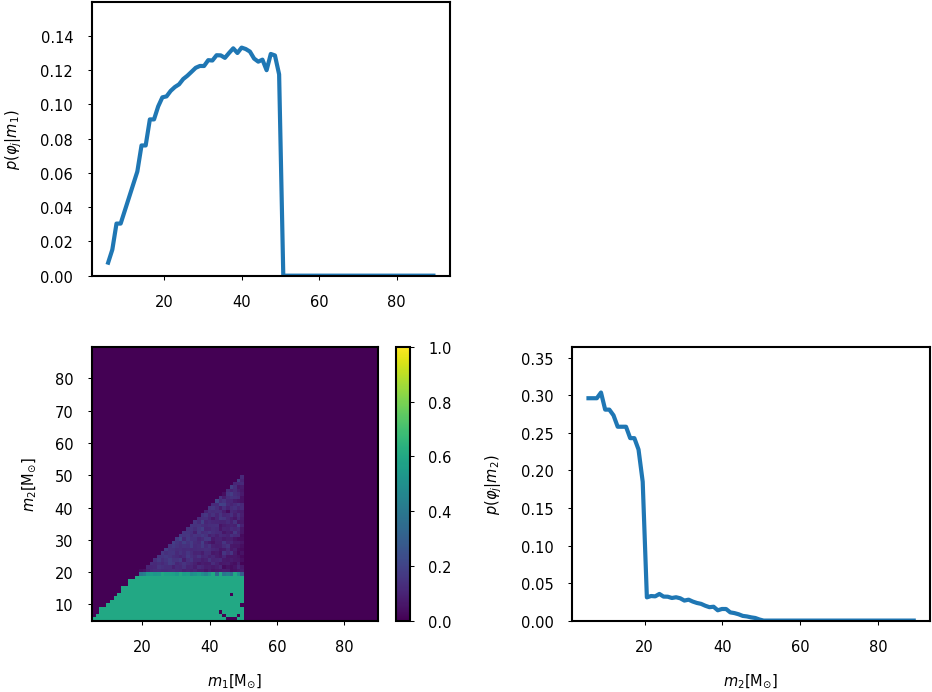

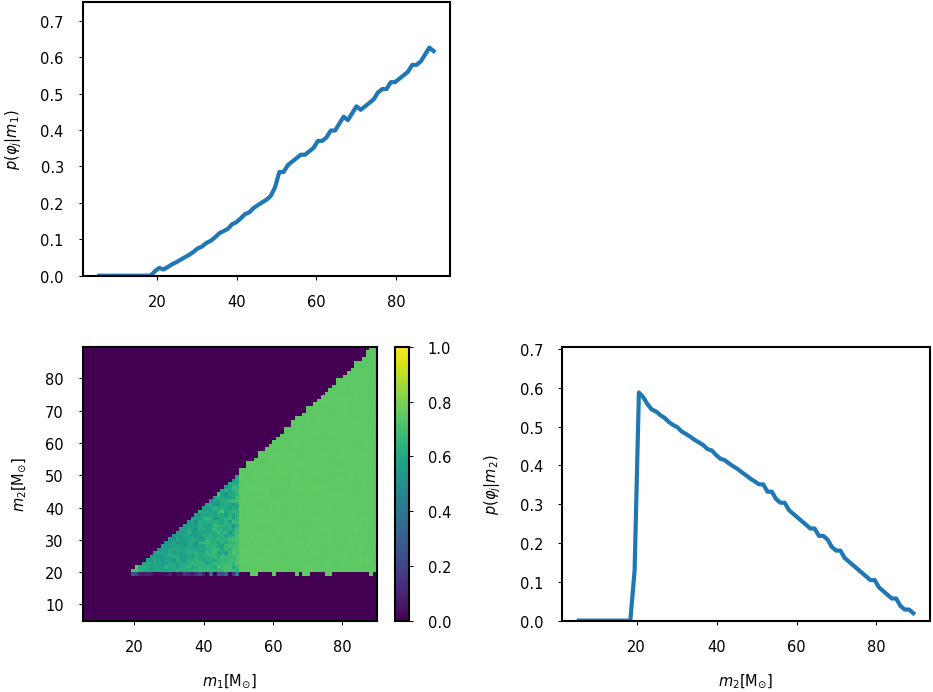

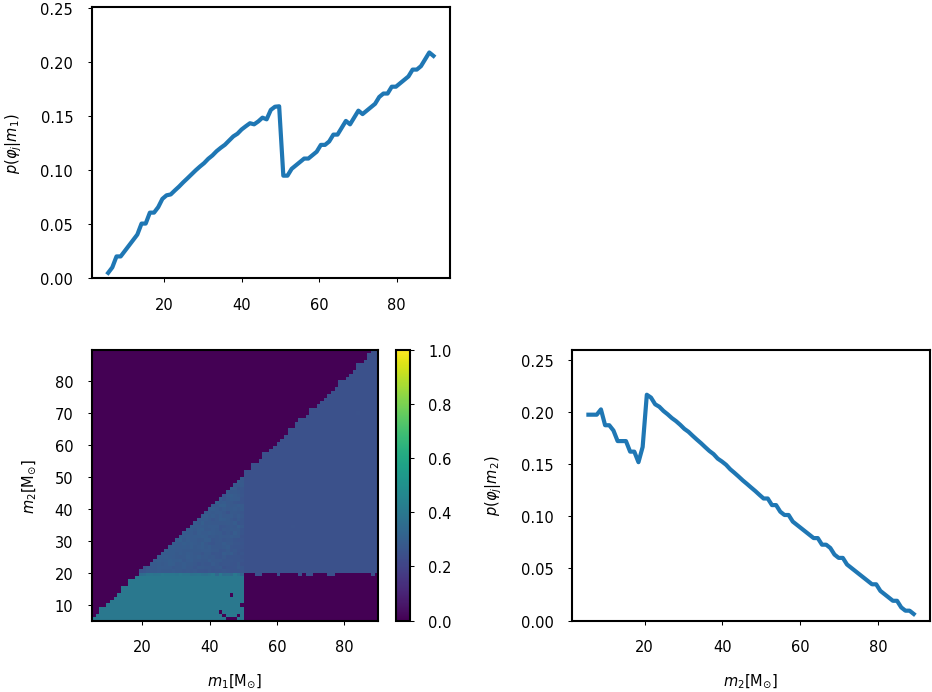

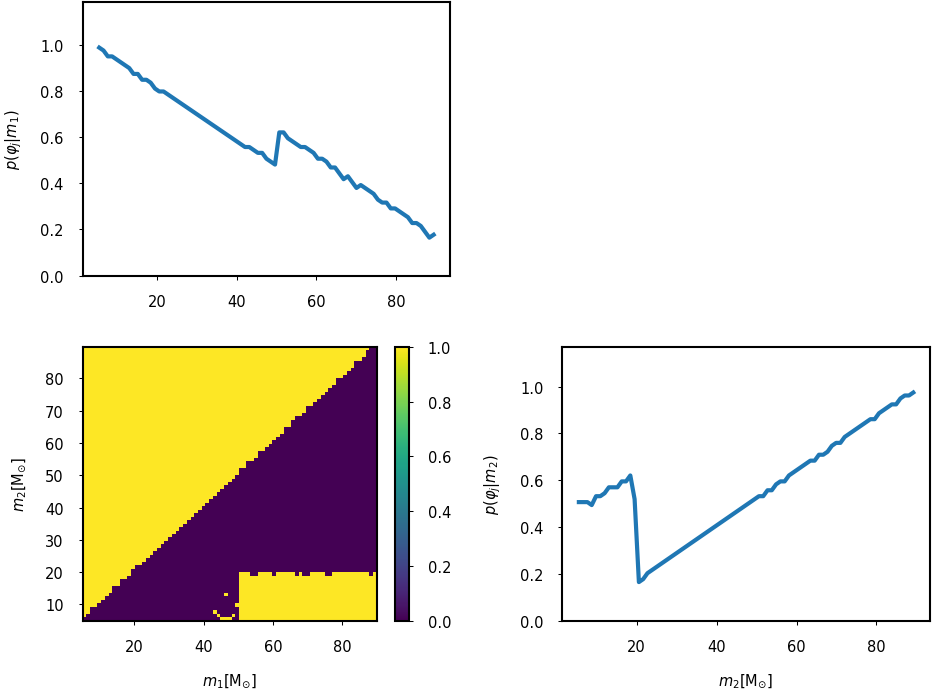

In [16]:
listofpop.plot_pmodel_given_theta('model_0',bins)
plt.tight_layout()
listofpop.plot_pmodel_given_theta('model_1',bins)
plt.tight_layout()
listofpop.plot_pmodel_given_theta('True',bins)
plt.tight_layout()
listofpop.plot_pmodel_given_theta('null',bins)
plt.tight_layout()

In [17]:
# We can see that the total model (the correct one) is 9 times more preferred than the null model. The others are not believable.
outer=listofpop.calculate_phehom_match(pop_reco_list,bins=bins,list_of_Nexp=Nreco)
print(outer)

/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:127: RuntimeWarning: divide by zero encountered in log
  norm_factor.append(_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model)+logNpart)
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:129: RuntimeWarning: divide by zero encountered in log
  self.population_list[key].log_p_model_given_theta=_np.log(self.population_list[key].p_model_given_theta)+_np.log(self.population_list[key].prior_model*_np.exp(logNpart))
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:138: RuntimeWarning: invalid value encountered in subtract
  self.population_list[key].log_p_model_given_theta-=log_norm_factor
/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:144: RuntimeWarning: divide by zero encountered in log
  self.log_p_null_model_given_theta=_np.log(self.p_null_model_given_theta)


{'model_0': 0.0, 'model_1': 0.0, 'True': 0.9215785333333321, 'null': 0.07842146666666794}


# The posterior object

Now we will see the posterior sample objects. These are objects needed to handle posterior samples on the GW parameter of a GW. We need to posteriors when we want to match our synthetic models to real data by defining some particular analyses (see below)

In [18]:
import h5py 
import gwparents
import numpy as np
import os

In [19]:
# We will download now a posterior file from LIGO, Virgo and KAGRA
!wget https://zenodo.org/record/5117703/files/IGWN-GWTC2p1-v1-GW190916_200658_PEDataRelease.h5?download=1

--2022-06-22 17:06:35--  https://zenodo.org/record/5117703/files/IGWN-GWTC2p1-v1-GW190916_200658_PEDataRelease.h5?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119374963 (114M) [application/octet-stream]
Saving to: ‘IGWN-GWTC2p1-v1-GW190916_200658_PEDataRelease.h5?download=1’

IGWN-GWTC2p1-v1-GW1 100%[===================>] 113,84M  24,8MB/s    in 4,8s    

2022-06-22 17:06:41 (23,5 MB/s) - ‘IGWN-GWTC2p1-v1-GW190916_200658_PEDataRelease.h5?download=1’ saved [119374963/119374963]



In [20]:
f=h5py.File('IGWN-GWTC2p1-v1-GW190916_200658_PEDataRelease.h5?download=1','r')

In [21]:
os.remove('IGWN-GWTC2p1-v1-GW190916_200658_PEDataRelease.h5?download=1')

In [22]:
# We readh a posterior sample file
pos = f['IMRPhenomXPHM/posterior_samples']
# We extract masses and redshift, you can extract whatever you want
popbin={'mass_1_source':{'values':pos['mass_1_source'],'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':pos['mass_2_source'],'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':pos['redshift'],'tex_label':r'$z$','tex_var':r'z'}}



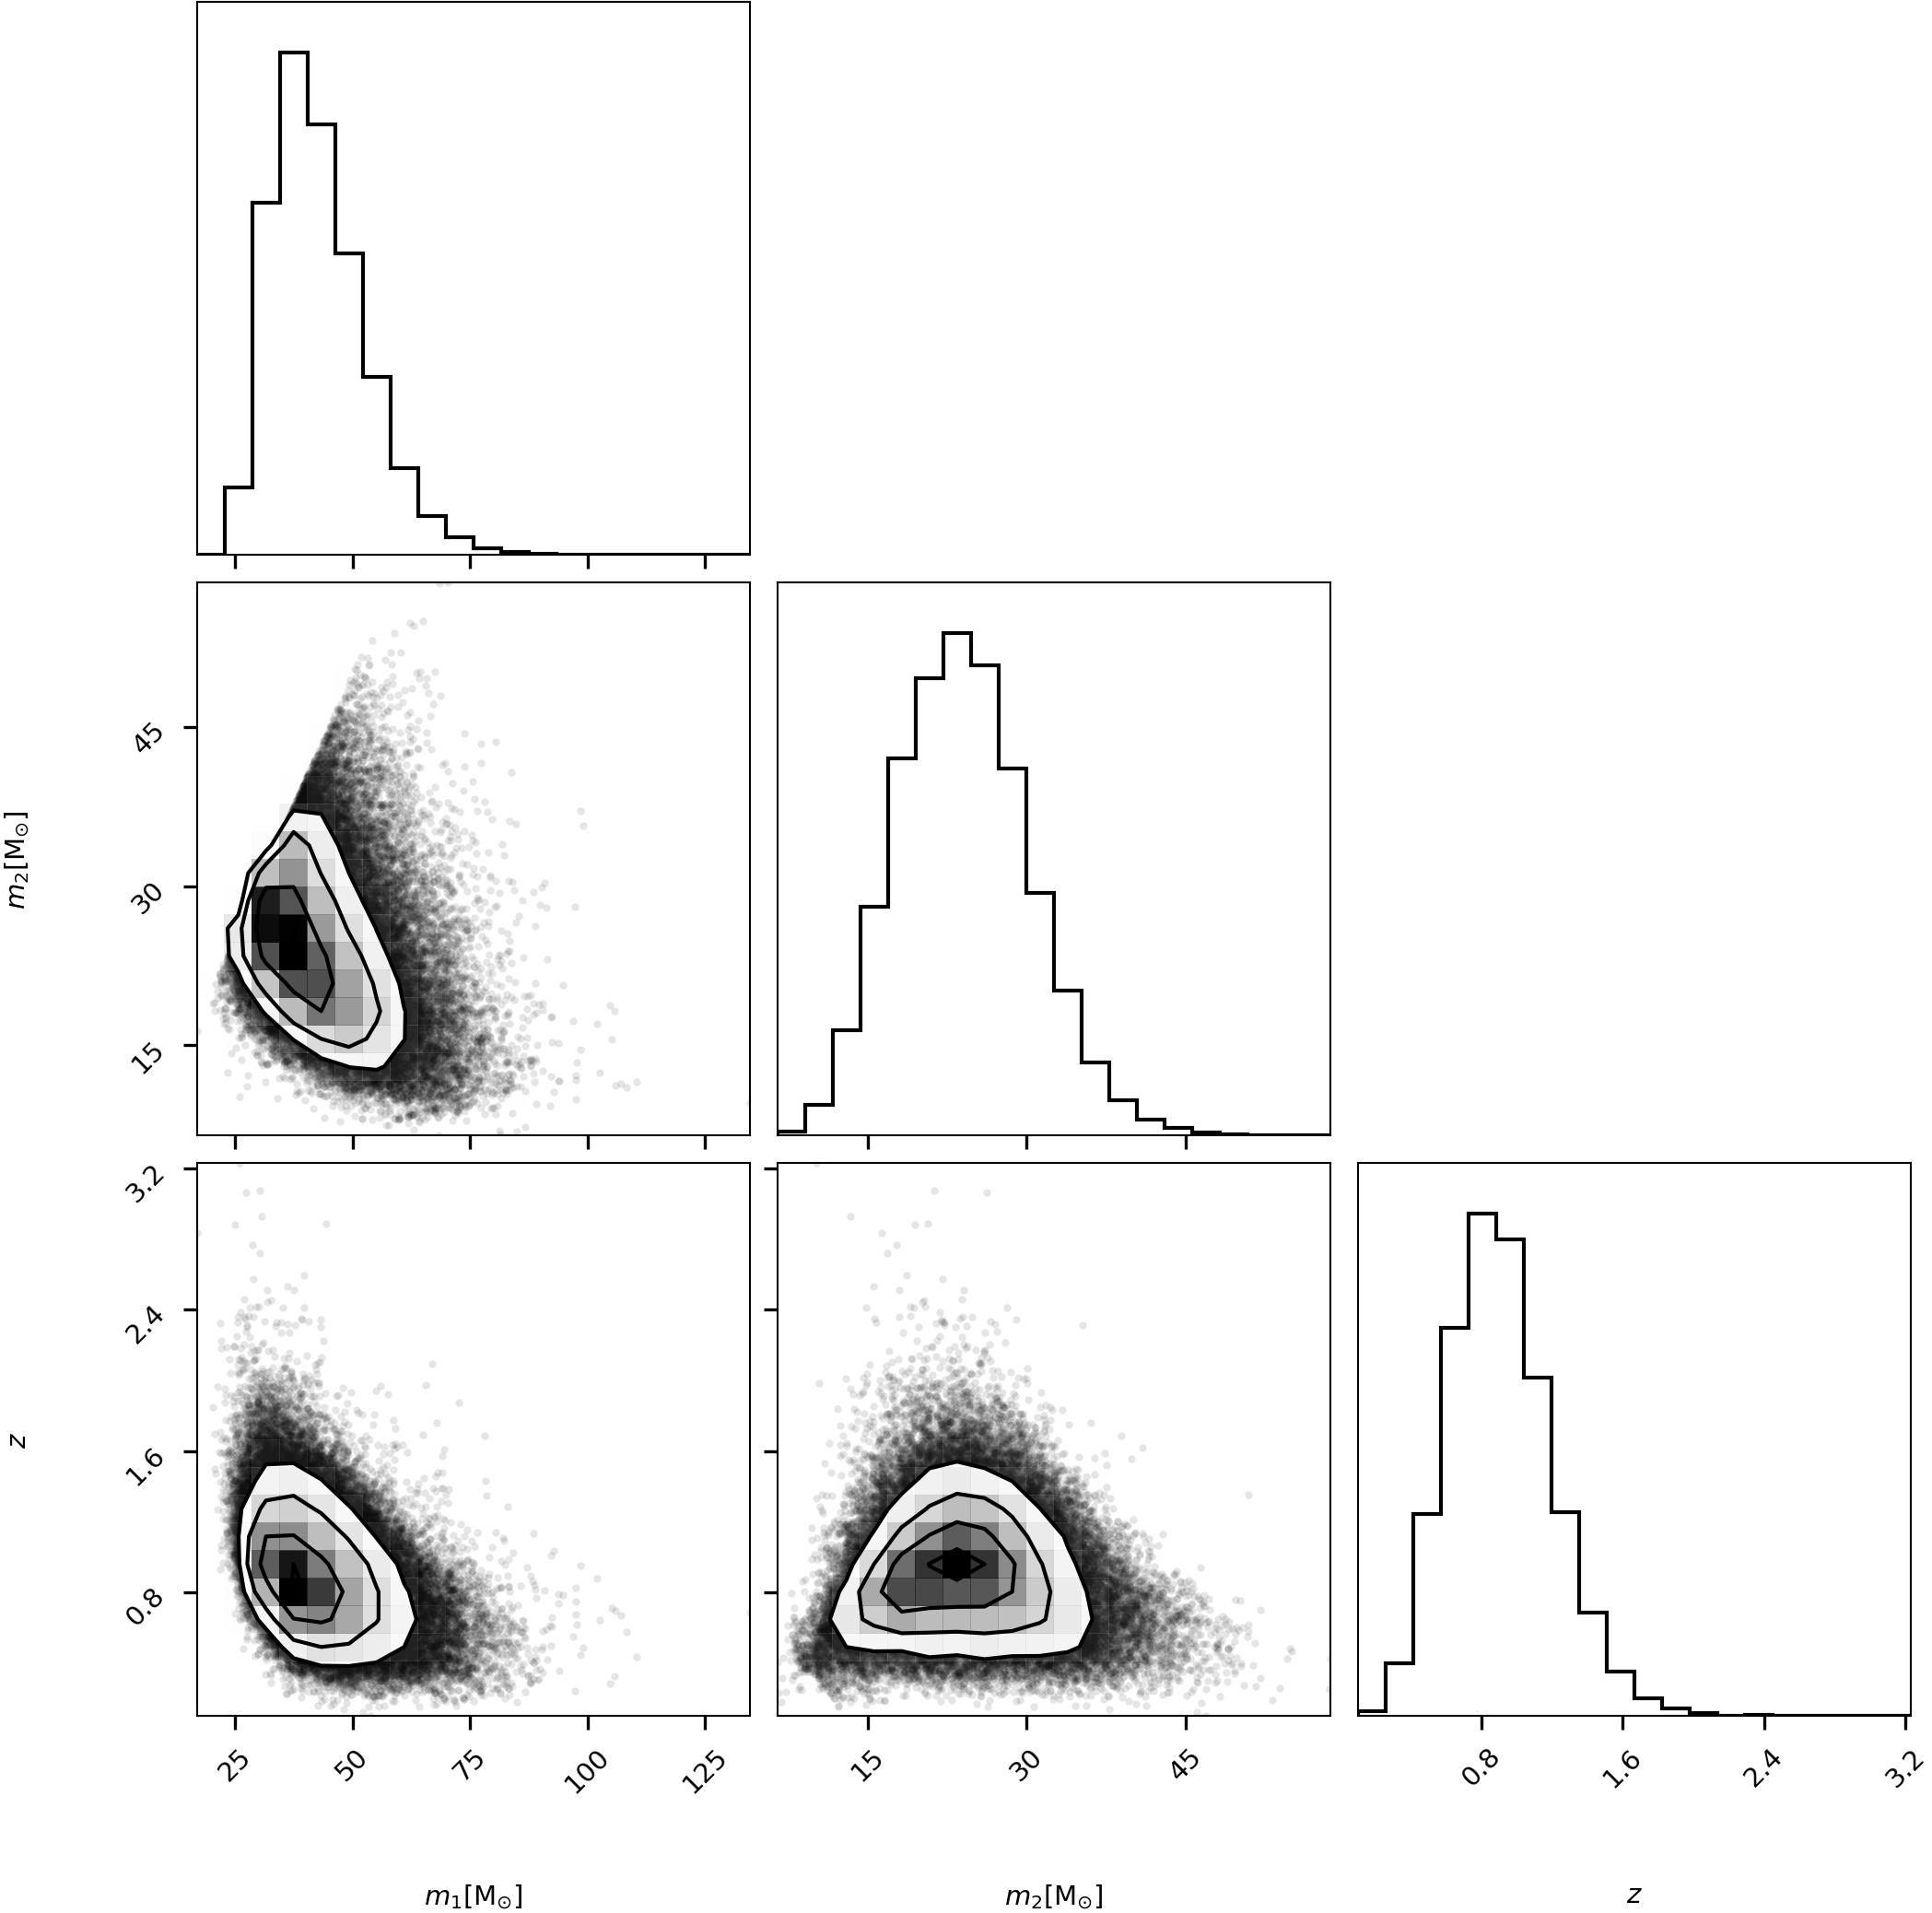

In [23]:
# We initialize the posterior samples and histogram them
GWs=gwparents.posterior.posterior('GW190916_200658',popbin,prior_to_rem=np.ones_like(popbin['mass_1_source']['values']))
_=GWs.histogram_samples()

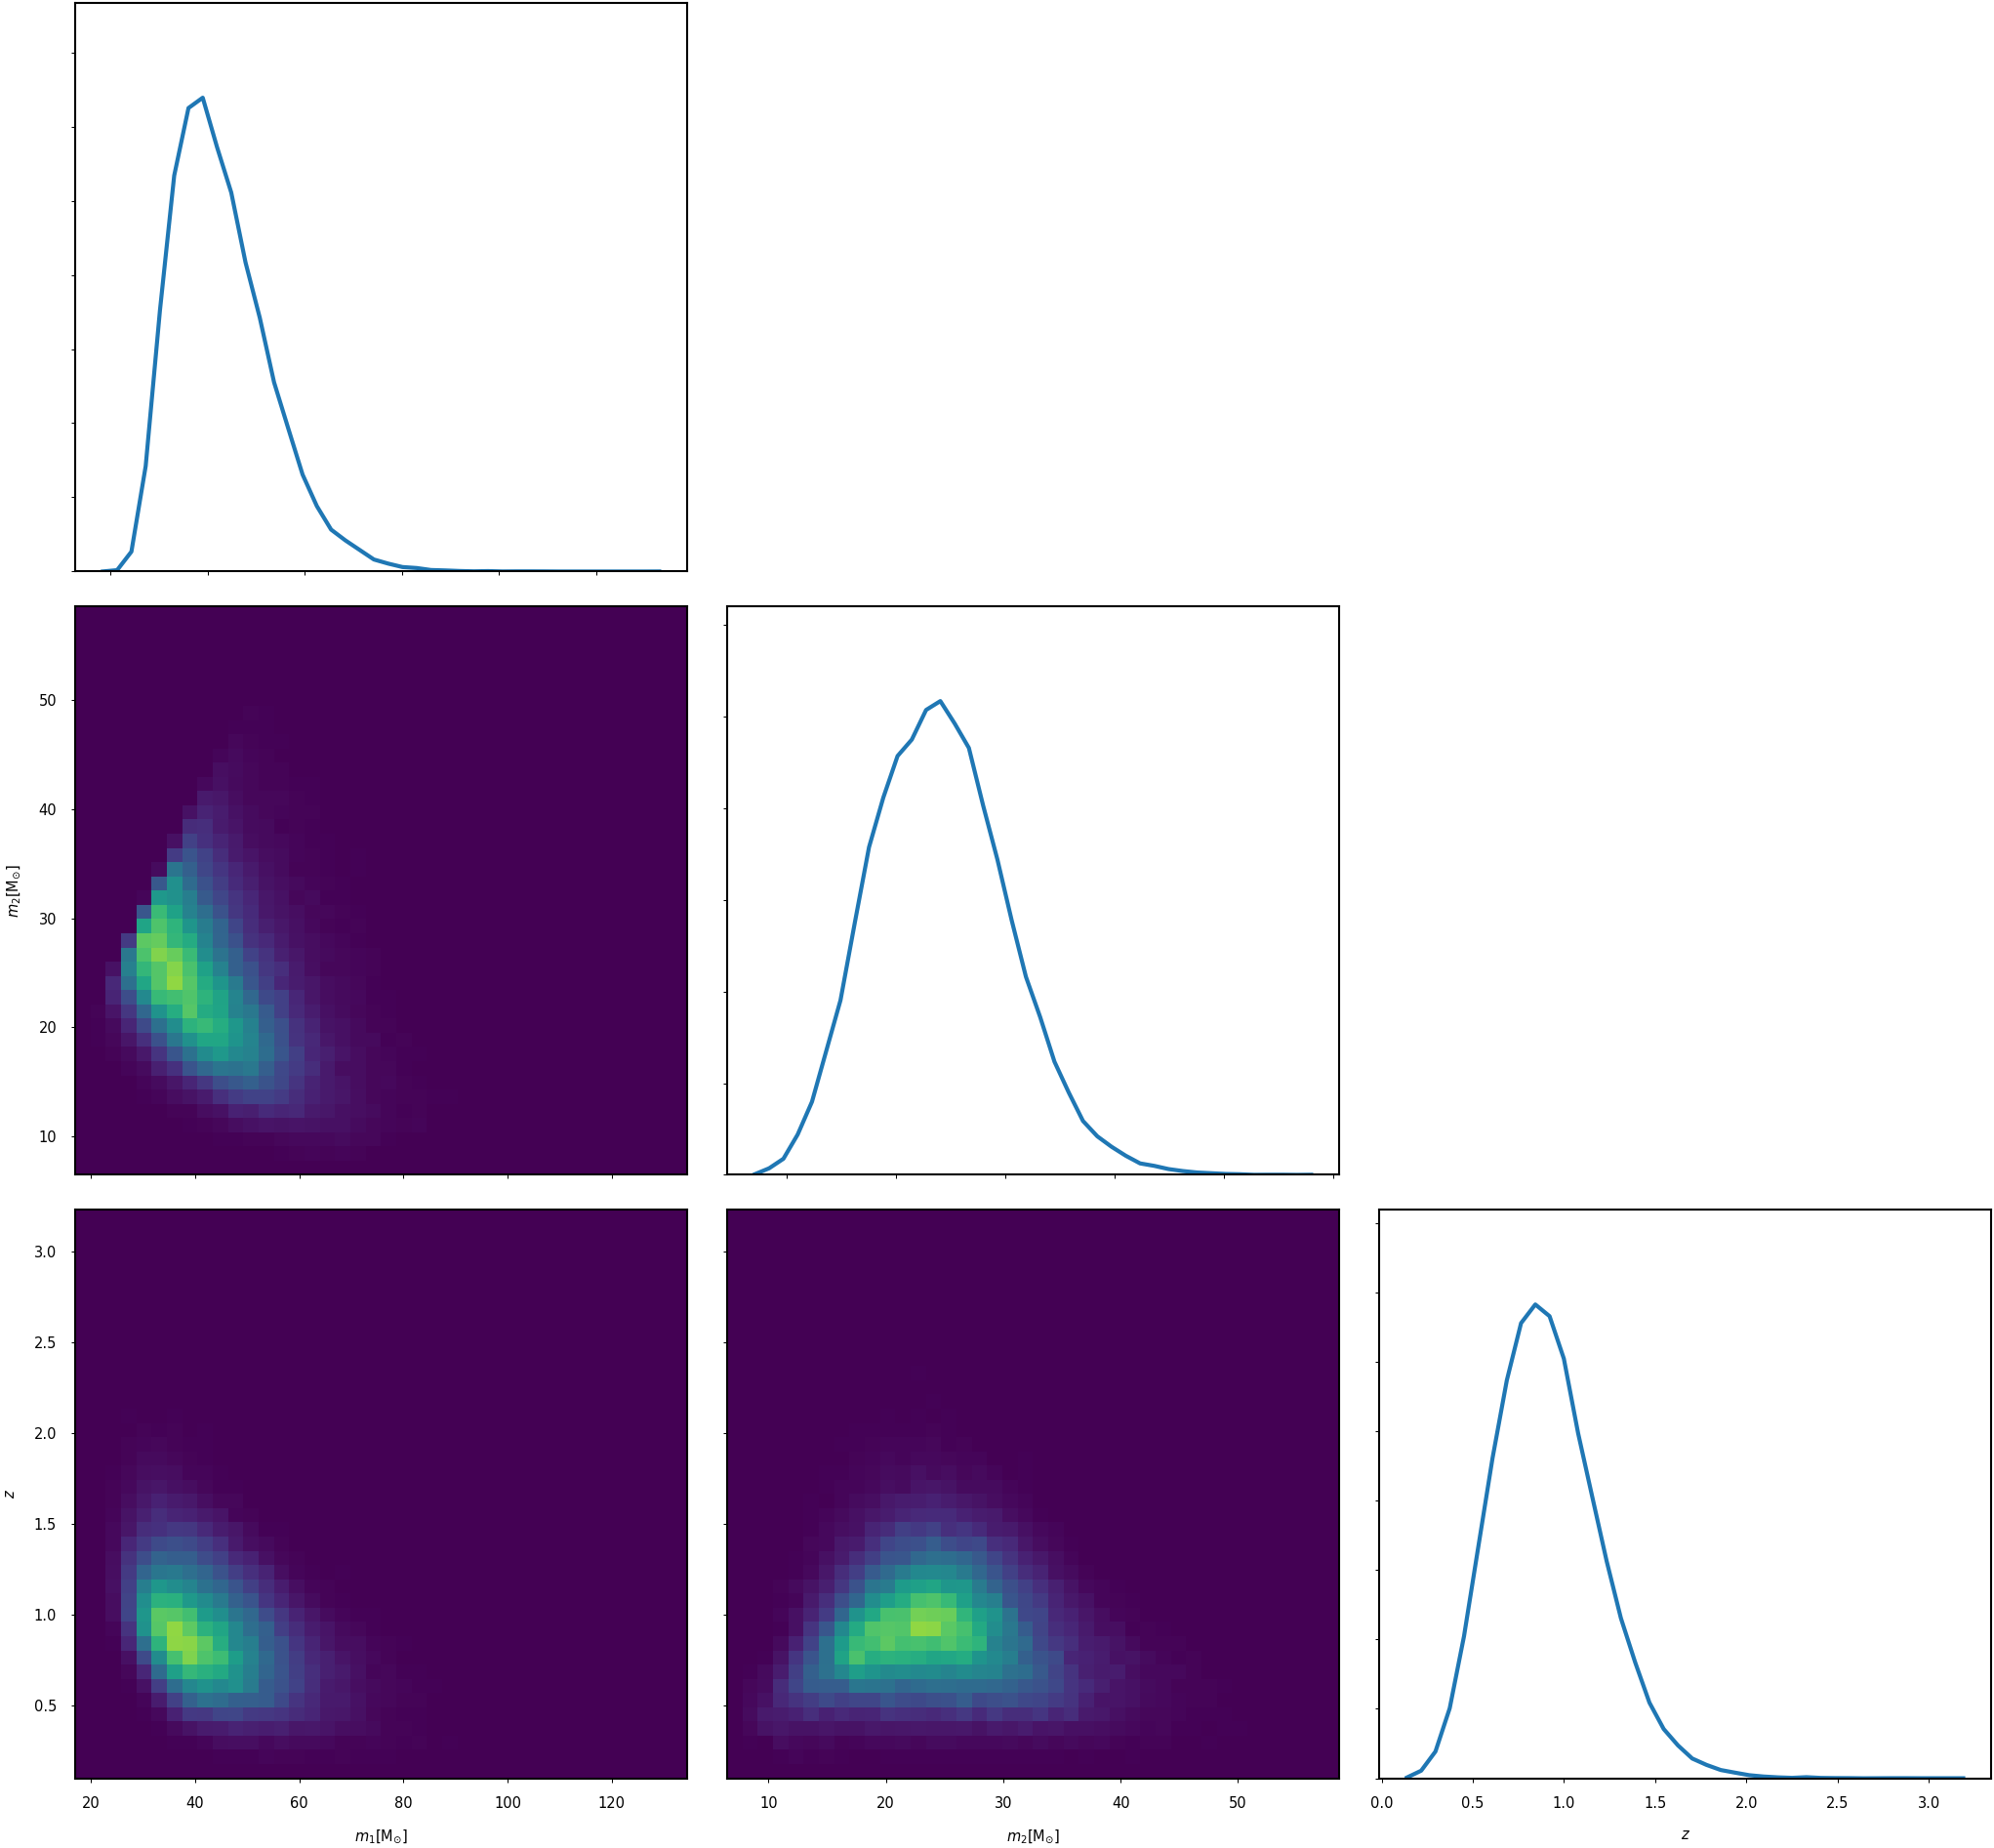

In [24]:
## One of the key component of the analysis is the possibility of fitting the gaussian kernel of the 
# parameters posterior. We have two ways, using a ndhistogram or using a kde fitting.
# KDE fitting: Pro: Very general, no problem of discretization Cons: Usually fails on boundaries and with very strong
# banana shapes
# Histogram fitting: Pro: More robust. Cons: Could suffer discretization (too fine or too corse)

## Here we will use the histogram method with a 40X40X40 bin
GWs.kernelize(kernel_mode='histogram',bins={'mass_1_source':40,'mass_2_source':40,'redshift':40})
## We histogram the kernel to see possible difficulties in the fit
_=GWs.histogram_kernel()

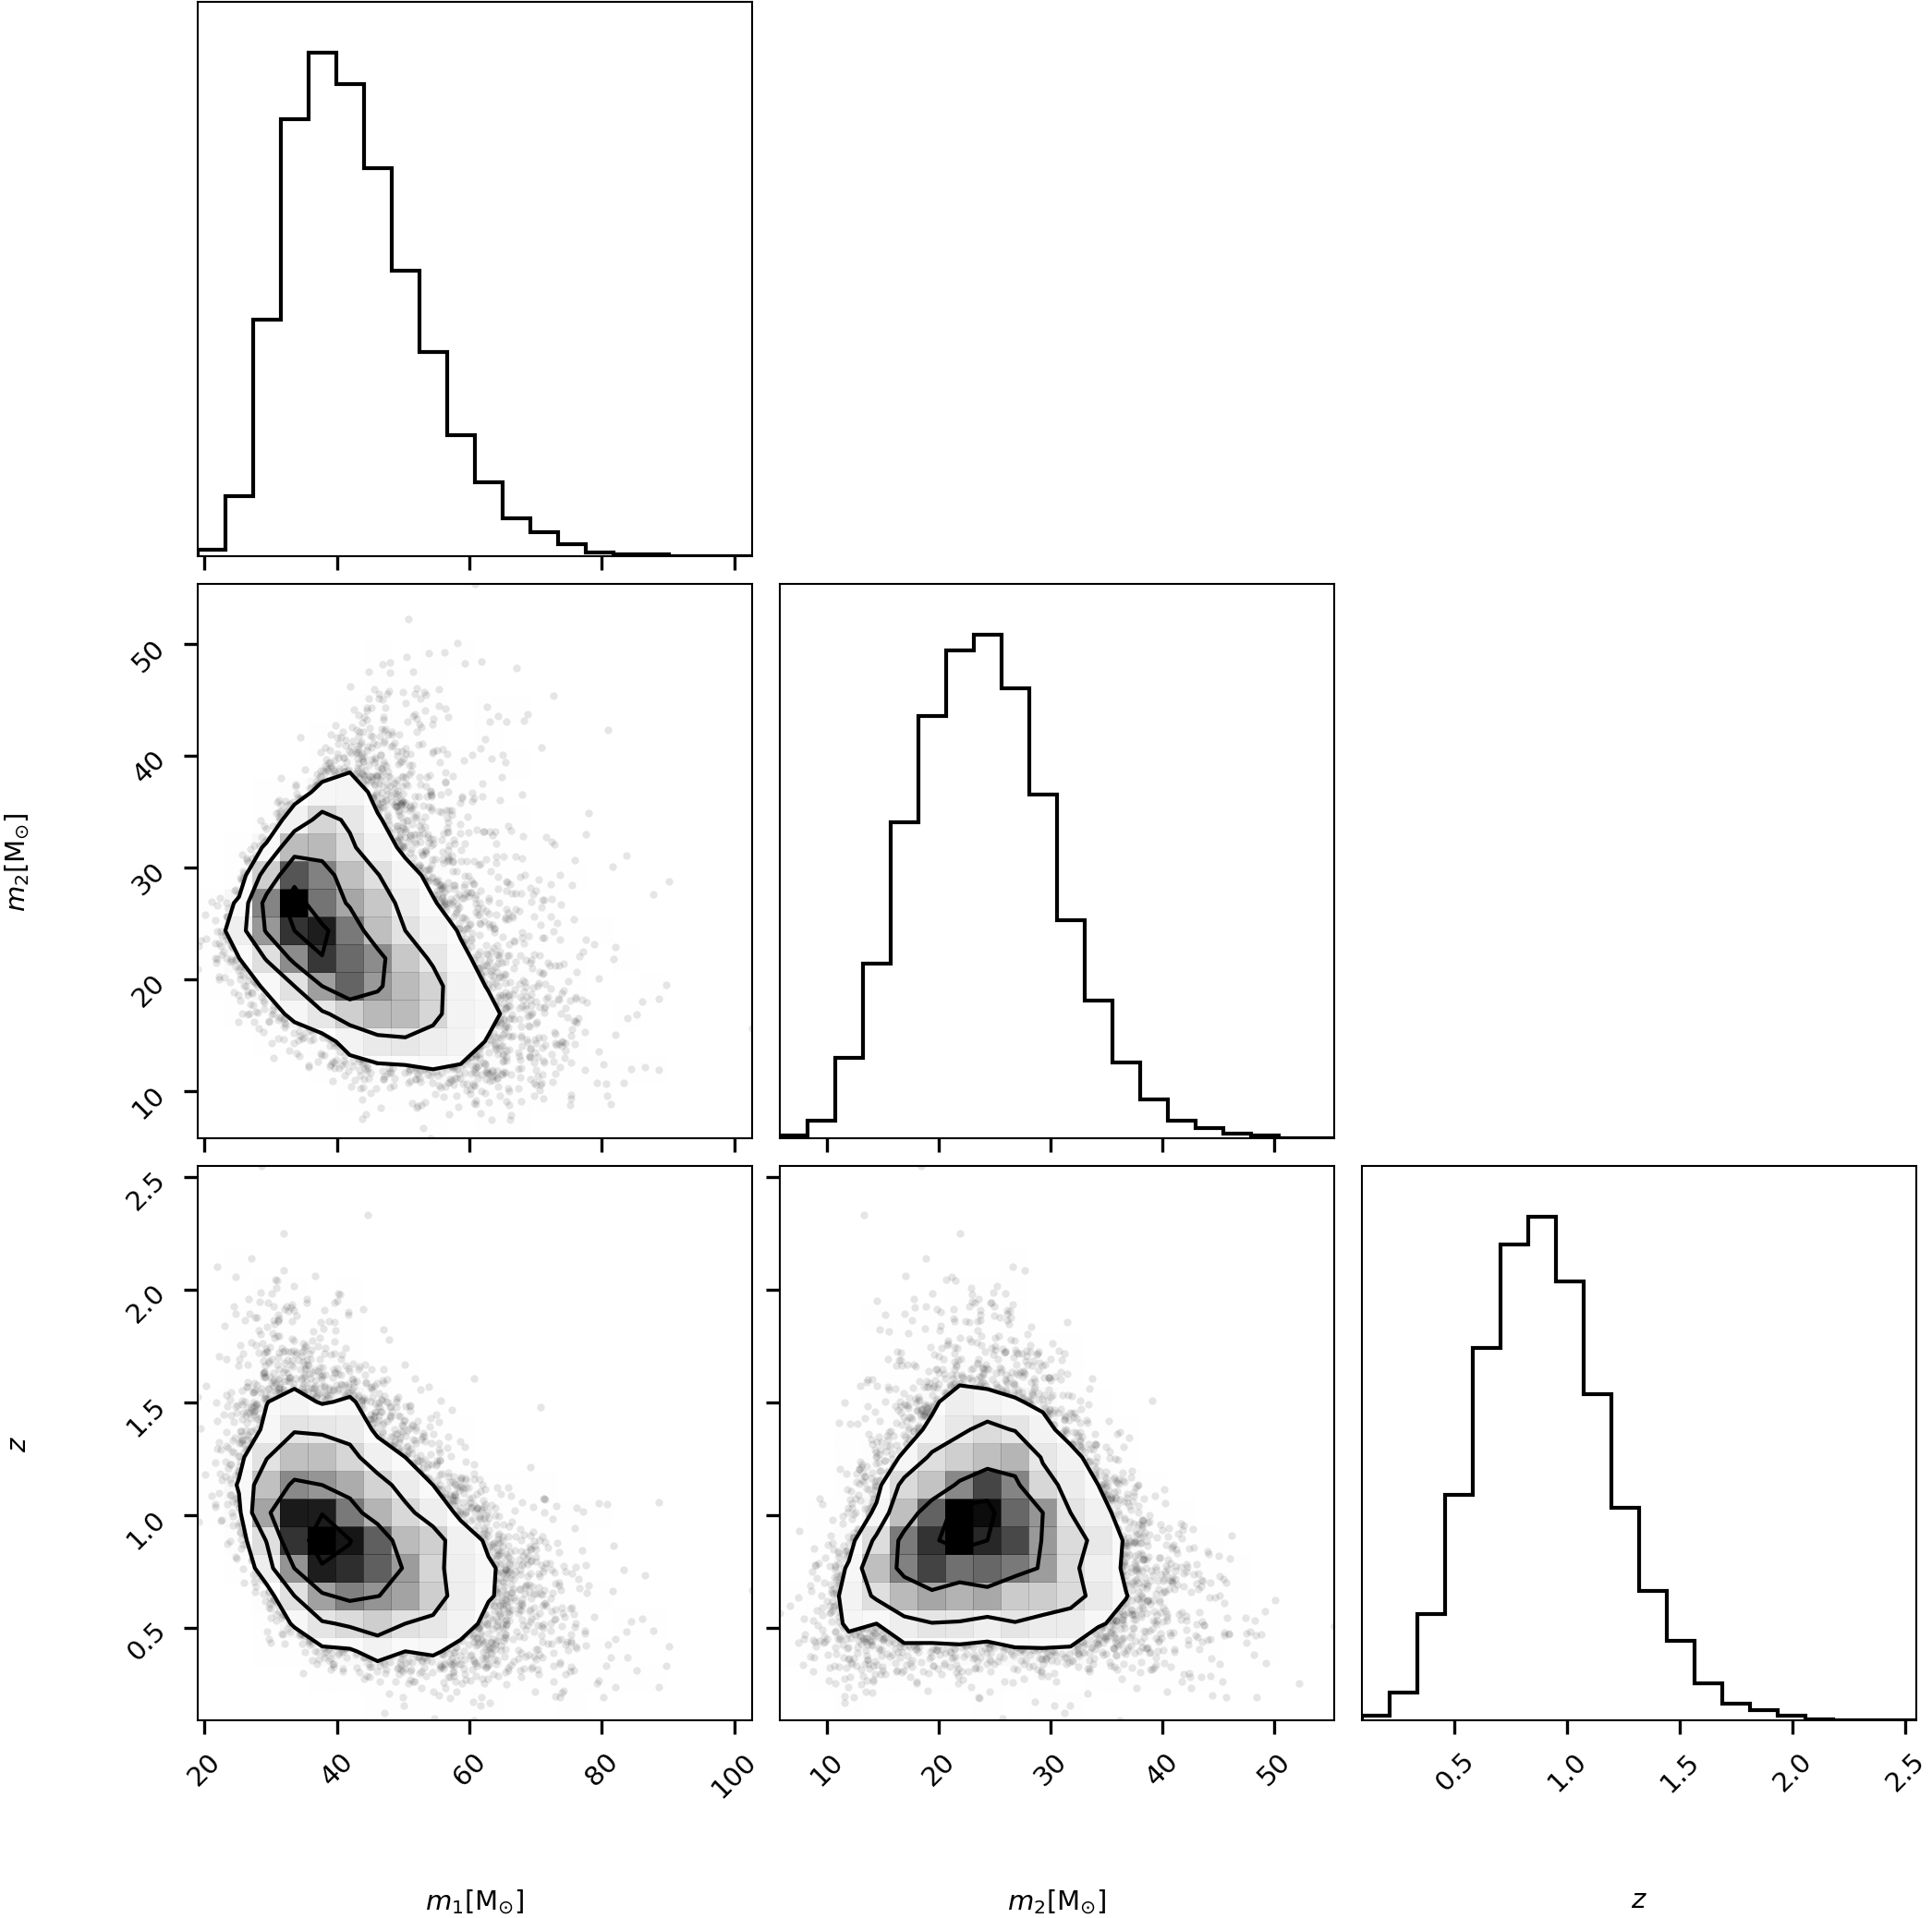

In [25]:
# Same as above but with gaussian kernel fitting
GWs.kernelize(kernel_mode='kde')
_=GWs.histogram_kernel()

# Hierachical analyses on data

Now we will show how one can perform hierarchical analyses on data. These consist in matching the sythetic population to a list of GW event. We will perform two kind of analyses

1) An analysis in which we want to fit the mixture fraction between two competitive models, i.e. the true underlying model is a mixture of a part of a model and a part of the other. An example: You simulated an entire population of BBH with a common envelop parameter alpha_1 (model_1) and you simulated another entire population with alpha_2.

2) An analysis in which the true model is not a sum of mixture fractions but a sum of absolute values. Example: You made a simulation and then divided your binaries in metallicity bin. Clearly the overall population should not be a fractional mixture but the sum of all the binaries

## A 1d example with two models using absolute fractions

In [26]:
import icarogw
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gwparents
from astropy.cosmology import Planck15
import pickle


## We initialize the true population, a PLG
R0=0.6
Tobs=.1
zcut=3.0
zlim=np.linspace(0,2.5,10000)
true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':0.5})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(10000)
zs=true_redshift_distro.sample(10000)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}


pop_0=gwparents.synthetic_population.synthetic_population('model_0',Ntotal,popbin,prior_to_rem=np.ones(10000),prior_model=1.,Tobs=Tobs)


/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:161: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:159: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/smastro/anaconda3/envs/gwparents/lib/py

In [27]:
print('Expecting {:.0f} signals'.format(pop_0.expected_detections))

Expecting 227 signals


In [28]:
# We generate delta-like injections 
pop_0.generate_delta_like_injections('examples/',int(pop_0.expected_detections),sigma={'mass_1_source':0.04,
                                                                               'mass_2_source':0.04,
                                                                               'redshift':0.04},Nsamp=10000,mode='gaussian')

In [29]:
list_pos=[]
for i in range(int(pop_0.expected_detections)):
    data=pickle.load(open('examples/injection_{:d}.p'.format(i),'rb'))
    list_pos.append(gwparents.posterior.posterior('GW_'+str(i),data,prior_to_rem=np.ones(10000)))

list_of_pos=gwparents.posterior.list_of_posteriors(list_pos)

In [30]:
## We now generate two competing models the first is the true one and the second is another powerlaw plus peak
## In this example we will not use mixture fractions


true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':0.5})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(100000)
zs=true_redshift_distro.sample(100000)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_0=gwparents.synthetic_population.synthetic_population('True',Ntotal,popbin,prior_to_rem=np.ones(100000),prior_model=1.,Tobs=Tobs)


true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':1.0})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(100000)
zs=true_redshift_distro.sample(100000)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_1=gwparents.synthetic_population.synthetic_population('Wrong',Ntotal,popbin,prior_to_rem=np.ones(100000),prior_model=1.,Tobs=Tobs)


listofpop=gwparents.synthetic_population.list_of_populations([pop_0,pop_1])

/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:552: RuntimeWarning: divide by zero encountered in log1p
  return _np.logaddexp(_np.log1p(-self.lambda_g)+self.pl.log_prob(x),_np.log(self.lambda_g)+self.gg.log_prob(x))


In [31]:
# We define the mixture analysis
mixt=gwparents.analyses.mixture_analyis(list_of_pos,listofpop,montecarlo_mode='posterior',scale_free=False)

In [32]:
# We initialize the matrix to calculate the hierarchical likelihood
mixt.calculate_loglij_logsj_logexp_arrays(kernel_mode='histogram',bins={'mass_1_source':30,
                                                                       'mass_2_source':30,
                                                                       'redshift':30})

Kernelizing populations: 2it [00:00, 121.45it/s]
Calculating match for Posterior #: 0it [00:00, ?it/s]/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:572: RuntimeWarning: divide by zero encountered in log
  log_lij=_logsumexp(_np.log(self.kernel[list_of_index])-_np.log(prior_to_rem[idxfinal]))-_np.log(total_samples_j)
Calculating match for Posterior #: 226it [00:01, 201.00it/s]


In [33]:
# You can check the values of the Monte carlo integral here
np.sum(mixt.loglij,axis=1)

array([-17.30399404, -11.48293635, -11.28418764,         -inf,
       -11.72695165, -10.60490584, -11.6908719 , -27.85508651,
       -12.48420218, -12.75853152, -13.26121064, -12.04142312,
       -10.64266737,         -inf, -12.89101832,         -inf,
       -14.36228218, -10.70112357, -19.65913799, -11.96020067,
       -18.12506258, -18.73040405, -14.25680448,         -inf,
       -10.9534338 ,         -inf,         -inf, -14.81852245,
       -18.19807941, -12.48087449, -13.52084478, -13.51436523,
       -10.2528267 ,         -inf,         -inf, -12.32972542,
       -12.34940066, -10.99983812, -12.88958601, -11.29988673,
               -inf, -17.4771292 , -11.80259894, -16.25962218,
       -10.57198392, -11.23065129,         -inf,         -inf,
       -12.12664124,         -inf, -11.24085901, -13.57138039,
       -16.88248923, -10.78189447,         -inf,         -inf,
       -10.21820521,  -9.94227037, -10.61909339, -21.78715053,
               -inf, -11.35085918, -10.45409802, -13.80

/home/smastro/git_repositories/gwparents/gwparents/analyses.py:205: RuntimeWarning: divide by zero encountered in log
  new_log_priors=_np.log(lambdasquare)+self.logNtot-_logsumexp(_np.log(lambdasquare)+self.logNtot)
/home/smastro/git_repositories/gwparents/gwparents/analyses.py:206: RuntimeWarning: divide by zero encountered in log
  new_log_priors[_np.log(lambdasquare)==-_np.inf]=-_np.inf
/home/smastro/git_repositories/gwparents/gwparents/analyses.py:208: RuntimeWarning: divide by zero encountered in log
  logNexp=self.logexpj+_np.log(lambdasquare)


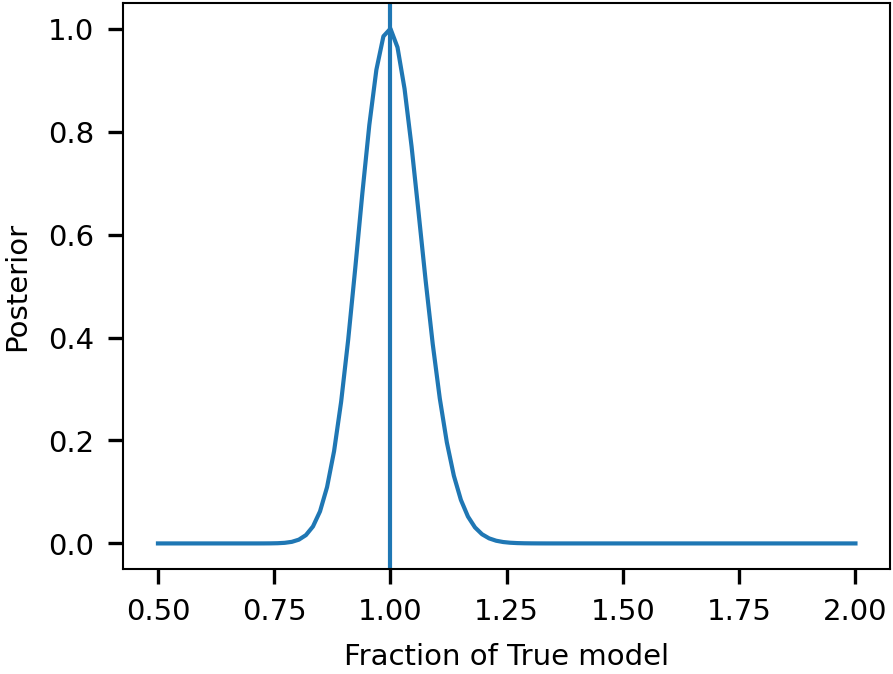

In [34]:
## We calculate a posterior on the absolute fraction of the first model, going from 0.1 to 2. Clearly the true value
## is at one

lambdas=np.linspace(0.5,2,100)
posterior=[]
for ll in lambdas:
    posterior.append(mixt.calculate_log_hierachical_likelihood({'True':ll,'Wrong':0.0},scale_free=False))
posterior=np.array(posterior)

plt.plot(lambdas,np.exp(posterior-posterior.max()))
plt.ylabel('Posterior')
plt.xlabel('Fraction of True model')
plt.axvline(1.0)

## A 1d example with two models using relative fractions

We will now use the same population as before but now we assume that we want to fit a mixture fraction. Our true model is an overlap of a powerlaw and a gaussian peak. So in this case we will define our competing models as a powerlaw PL and a gaussian peak G. We should find that the mixture fraction is 0.5

In [35]:
## We now generate two competing models the first is the true one and the second is another powerlaw plus peak
## In this example we will not use mixture fractions

true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':0.})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(100000)
zs=true_redshift_distro.sample(100000)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_0=gwparents.synthetic_population.synthetic_population('PL',Ntotal,popbin,prior_to_rem=np.ones(100000),prior_model=1.,Tobs=Tobs)


true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':1.0})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(100000)
zs=true_redshift_distro.sample(100000)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_1=gwparents.synthetic_population.synthetic_population('G',Ntotal,popbin,prior_to_rem=np.ones(100000),prior_model=1.,Tobs=Tobs)


listofpop=gwparents.synthetic_population.list_of_populations([pop_0,pop_1])

/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:552: RuntimeWarning: divide by zero encountered in log
  return _np.logaddexp(_np.log1p(-self.lambda_g)+self.pl.log_prob(x),_np.log(self.lambda_g)+self.gg.log_prob(x))
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:161: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:159: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.no

In [36]:
# We define the mixture analysis
mixt=gwparents.analyses.mixture_analyis(list_of_pos,listofpop,montecarlo_mode='posterior',scale_free=False)

In [37]:
# We initialize the matrix to calculate the hierarchical likelihood
mixt.calculate_loglij_logsj_logexp_arrays(kernel_mode='histogram',bins={'mass_1_source':30,
                                                                       'mass_2_source':30,
                                                                       'redshift':30})

Kernelizing populations: 2it [00:00, 109.55it/s]
Calculating match for Posterior #: 0it [00:00, ?it/s]/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:572: RuntimeWarning: divide by zero encountered in log
  log_lij=_logsumexp(_np.log(self.kernel[list_of_index])-_np.log(prior_to_rem[idxfinal]))-_np.log(total_samples_j)
Calculating match for Posterior #: 226it [00:01, 199.96it/s]


/home/smastro/git_repositories/gwparents/gwparents/analyses.py:205: RuntimeWarning: divide by zero encountered in log
  new_log_priors=_np.log(lambdasquare)+self.logNtot-_logsumexp(_np.log(lambdasquare)+self.logNtot)
/home/smastro/git_repositories/gwparents/gwparents/analyses.py:206: RuntimeWarning: divide by zero encountered in log
  new_log_priors[_np.log(lambdasquare)==-_np.inf]=-_np.inf
/home/smastro/git_repositories/gwparents/gwparents/analyses.py:208: RuntimeWarning: divide by zero encountered in log
  logNexp=self.logexpj+_np.log(lambdasquare)


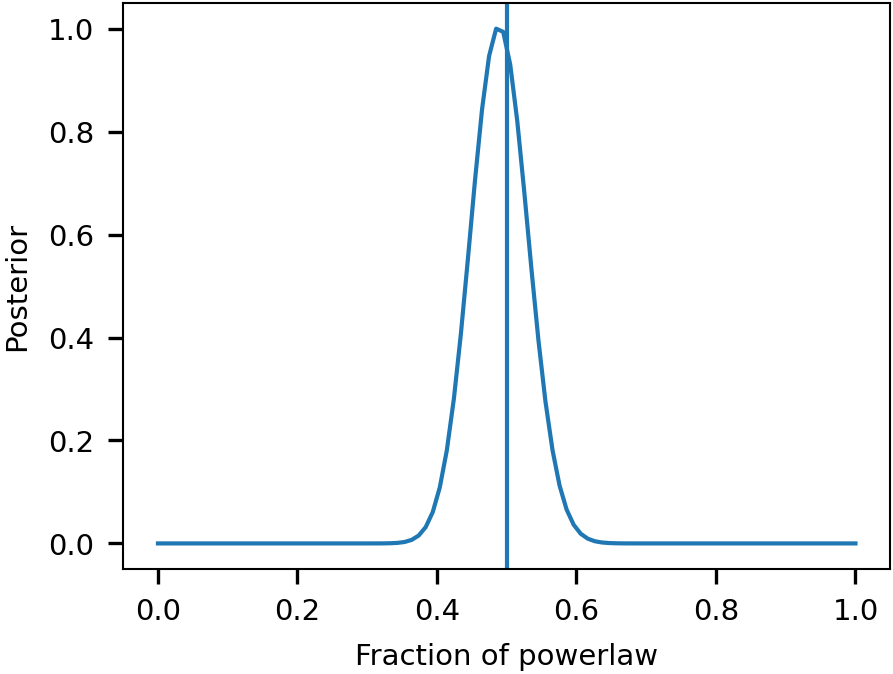

In [38]:
## We calculate a posterior on the absolute fraction of the first model, going from 0.1 to 2. Clearly the true value
## is at one. # note that we need to change the prior mode

lambdas=np.linspace(0.,1.0,100)
posterior=[]
for ll in lambdas:
    posterior.append(mixt.calculate_log_hierachical_likelihood({'PL':ll,'G':1-ll},scale_free=False))
posterior=np.array(posterior)

plt.plot(lambdas,np.exp(posterior-posterior.max()))
plt.ylabel('Posterior')
plt.xlabel('Fraction of powerlaw')
plt.axvline(0.5)

# Running bilby

We have also implemented the possibility of sampling absolute and fractional mixture coefficients using bilby. This is very useful when you are dealing with many models.

In [39]:
### We star by showing how Bilby works with three models. Again the true population is 
### 0.5 the first model and 0.5 the second model. In this example we sample relative fractions

Ngen=100000*5
true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':0.})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(Ngen)
zs=true_redshift_distro.sample(Ngen)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_0=gwparents.synthetic_population.synthetic_population('PL',Ntotal,popbin,prior_to_rem=np.ones(Ngen),prior_model=1.,Tobs=Tobs)


true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':1.0})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(Ngen)
zs=true_redshift_distro.sample(Ngen)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_1=gwparents.synthetic_population.synthetic_population('G',Ntotal,popbin,prior_to_rem=np.ones(Ngen),prior_model=1.,Tobs=Tobs)



true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':-2.,
                                                                         'beta':1.})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(Ngen)
zs=true_redshift_distro.sample(Ngen)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_2=gwparents.synthetic_population.synthetic_population('PL2',Ntotal,popbin,prior_to_rem=np.ones(Ngen),prior_model=1.,Tobs=Tobs)



listofpop=gwparents.synthetic_population.list_of_populations([pop_0,pop_1,pop_2])

/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:552: RuntimeWarning: divide by zero encountered in log
  return _np.logaddexp(_np.log1p(-self.lambda_g)+self.pl.log_prob(x),_np.log(self.lambda_g)+self.gg.log_prob(x))
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:161: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:159: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.no

In [40]:
mixt=gwparents.analyses.mixture_analyis(list_of_pos,listofpop,montecarlo_mode='posterior',scale_free=False)

In [41]:
## Note that we need to pass the isotropic prior flag to tell the code that it needs to consider 
## fractional mixutures among all the models

pmode={'dirichlet':{key:bilby.core.prior.DeltaFunction(1.,name=key) for key in ['PL','G','PL2']}}
res=mixt.run_bilby(pmode=pmode,nlive=2000,
                   kernel_kwargs={'kernel_mode':'histogram','bins':{'mass_1_source':50,
                                                                        'mass_2_source':50,
                                                                        'redshift':50}},outdir='examples/')

Kernelizing populations: 3it [00:00, 22.09it/s]
Calculating match for Posterior #: 0it [00:00, ?it/s]/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:572: RuntimeWarning: divide by zero encountered in log
  log_lij=_logsumexp(_np.log(self.kernel[list_of_index])-_np.log(prior_to_rem[idxfinal]))-_np.log(total_samples_j)
Calculating match for Posterior #: 226it [00:01, 119.01it/s]
17:07 bilby INFO    : Running for label 'label', output will be saved to 'examples/'
17:07 bilby INFO    : Search parameters:
17:07 bilby INFO    :   theta_i2_1 = absoluteSineNdimensional(i=2, N=3)
17:07 bilby INFO    :   theta_i3_1 = absoluteSineNdimensional(i=3, N=3)
17:07 bilby INFO    :   alpha_syn0 = 1.0
17:07 bilby INFO    :   alpha_syn1 = 1.0
17:07 bilby INFO    :   alpha_syn2 = 1.0
17:07 bilby INFO    : Single likelihood evaluation took 2.606e-04 s


Using prior mode  dirichlet
{'theta_i2_1': absoluteSineNdimensional(i=2, N=3), 'theta_i3_1': absoluteSineNdimensional(i=3, N=3), 'alpha_syn0': DeltaFunction(peak=1.0, name='alpha_syn0', latex_label='alpha_syn0', unit=None), 'alpha_syn1': DeltaFunction(peak=1.0, name='alpha_syn1', latex_label='alpha_syn1', unit=None), 'alpha_syn2': DeltaFunction(peak=1.0, name='alpha_syn2', latex_label='alpha_syn2', unit=None)}
0it [00:00, ?it/s]

17:07 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 2000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 1200, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0e1c3b2fd0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
17:07 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:07 bilby INFO    : Using dynesty version 1.0.1
17:07 bilby INFO    : Using the bilby-implemented rwalk sa

13914it [04:10, 30.84it/s, bound:573 nc:101 ncall:7.7e+05 eff:1.8% logz=-487.87+/-0.06 dlogz:0.100>0.1] 

17:11 bilby INFO    : Written checkpoint file examples//label_resume.pickle
17:11 bilby INFO    : Writing 5353 current samples to examples//label_samples.dat


13916it [04:16, 54.23it/s, bound:573 nc:  1 ncall:7.7e+05 eff:2.1% logz=-487.77+/-0.06 dlogz:0.000>0.1]



17:11 bilby INFO    : Sampling time: 0:04:07.802118
17:11 bilby INFO    : Summary of results:
nsamples: 15916
ln_noise_evidence:    nan
ln_evidence: -487.773 +/-  0.060
ln_bayes_factor:    nan +/-  0.060



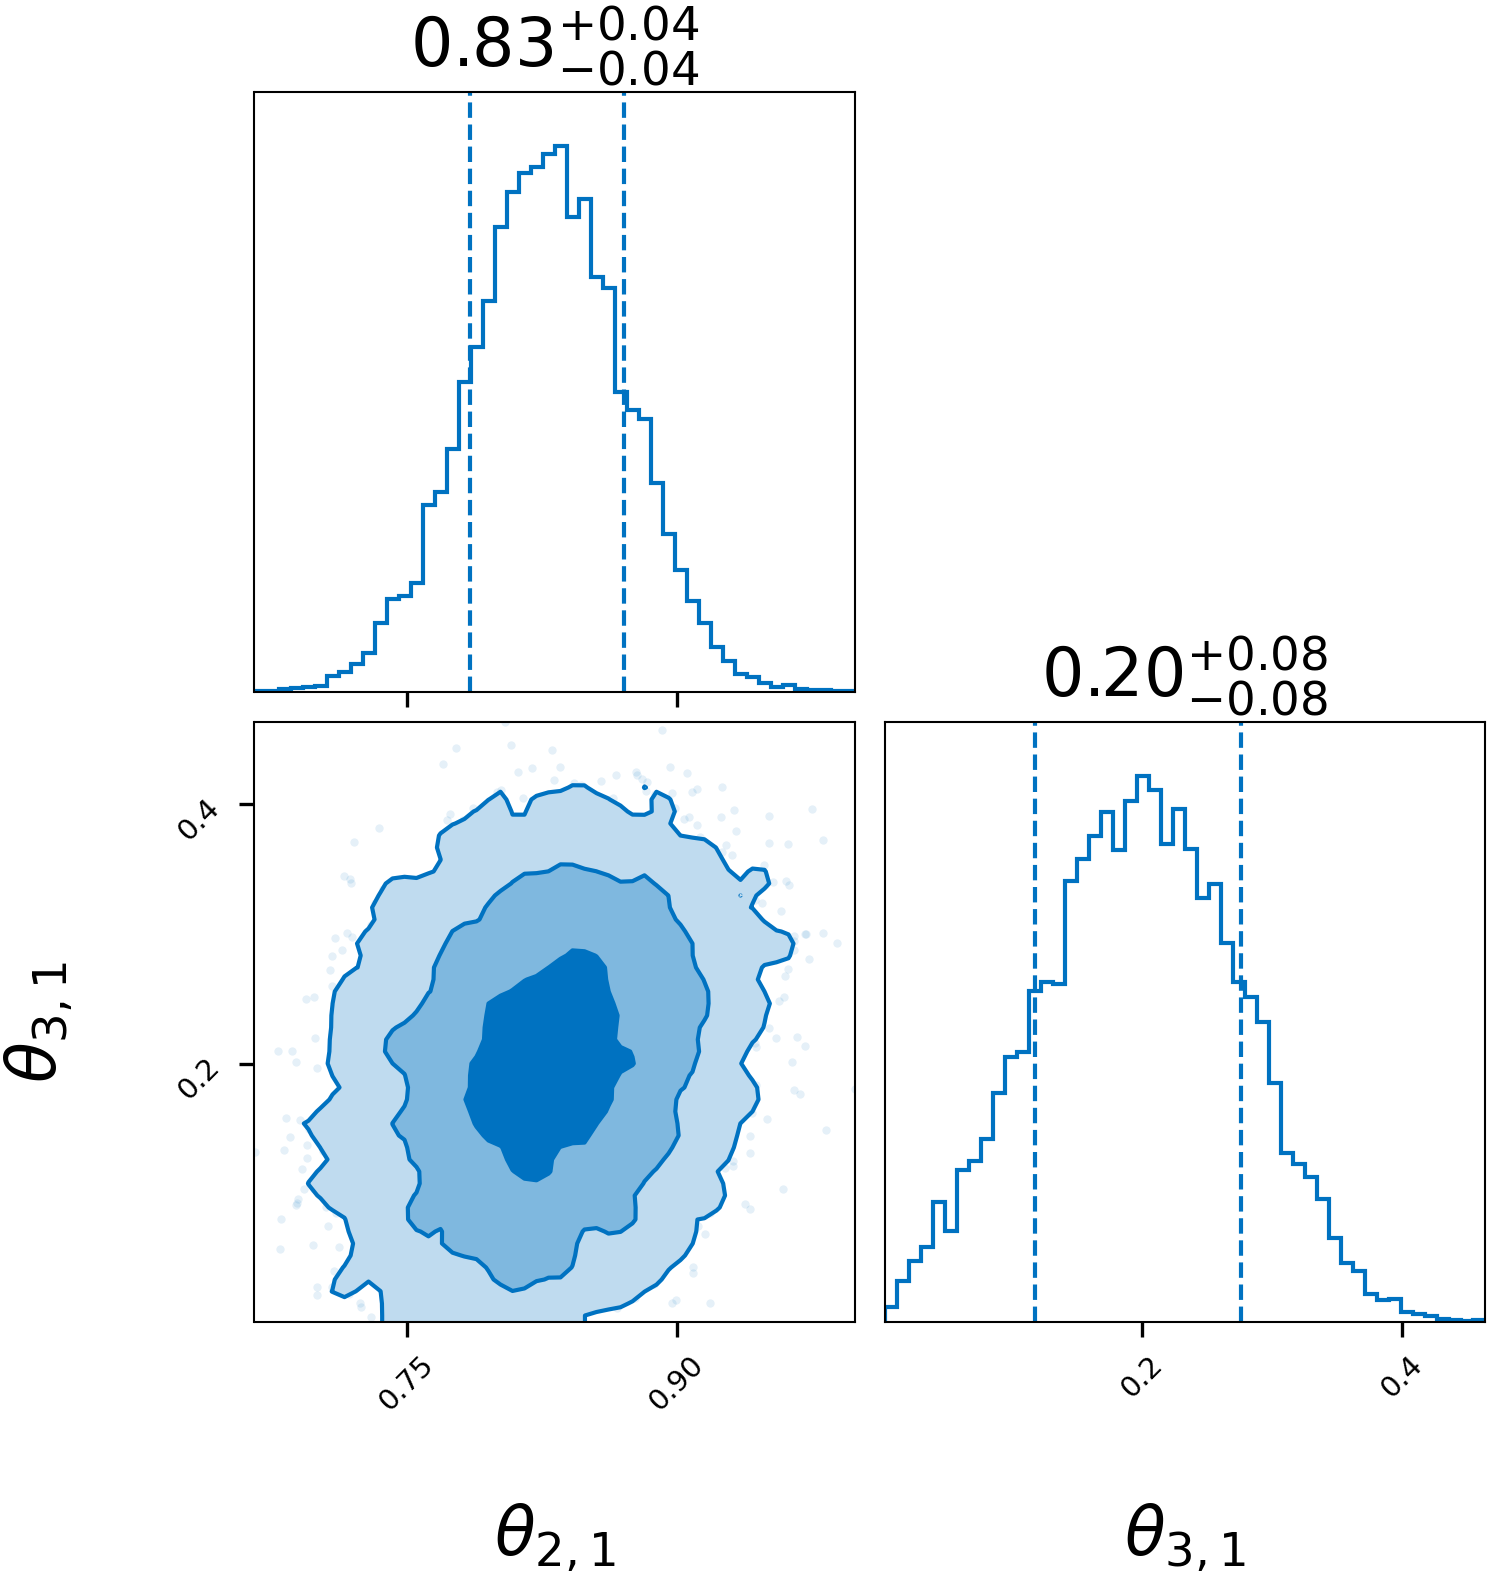

In [42]:
## When dealing with isotropic priors on model, the sampling is done in angles.
## By default the angles are computed with respect to a reference model, that is the last one you passed
res.plot_corner()

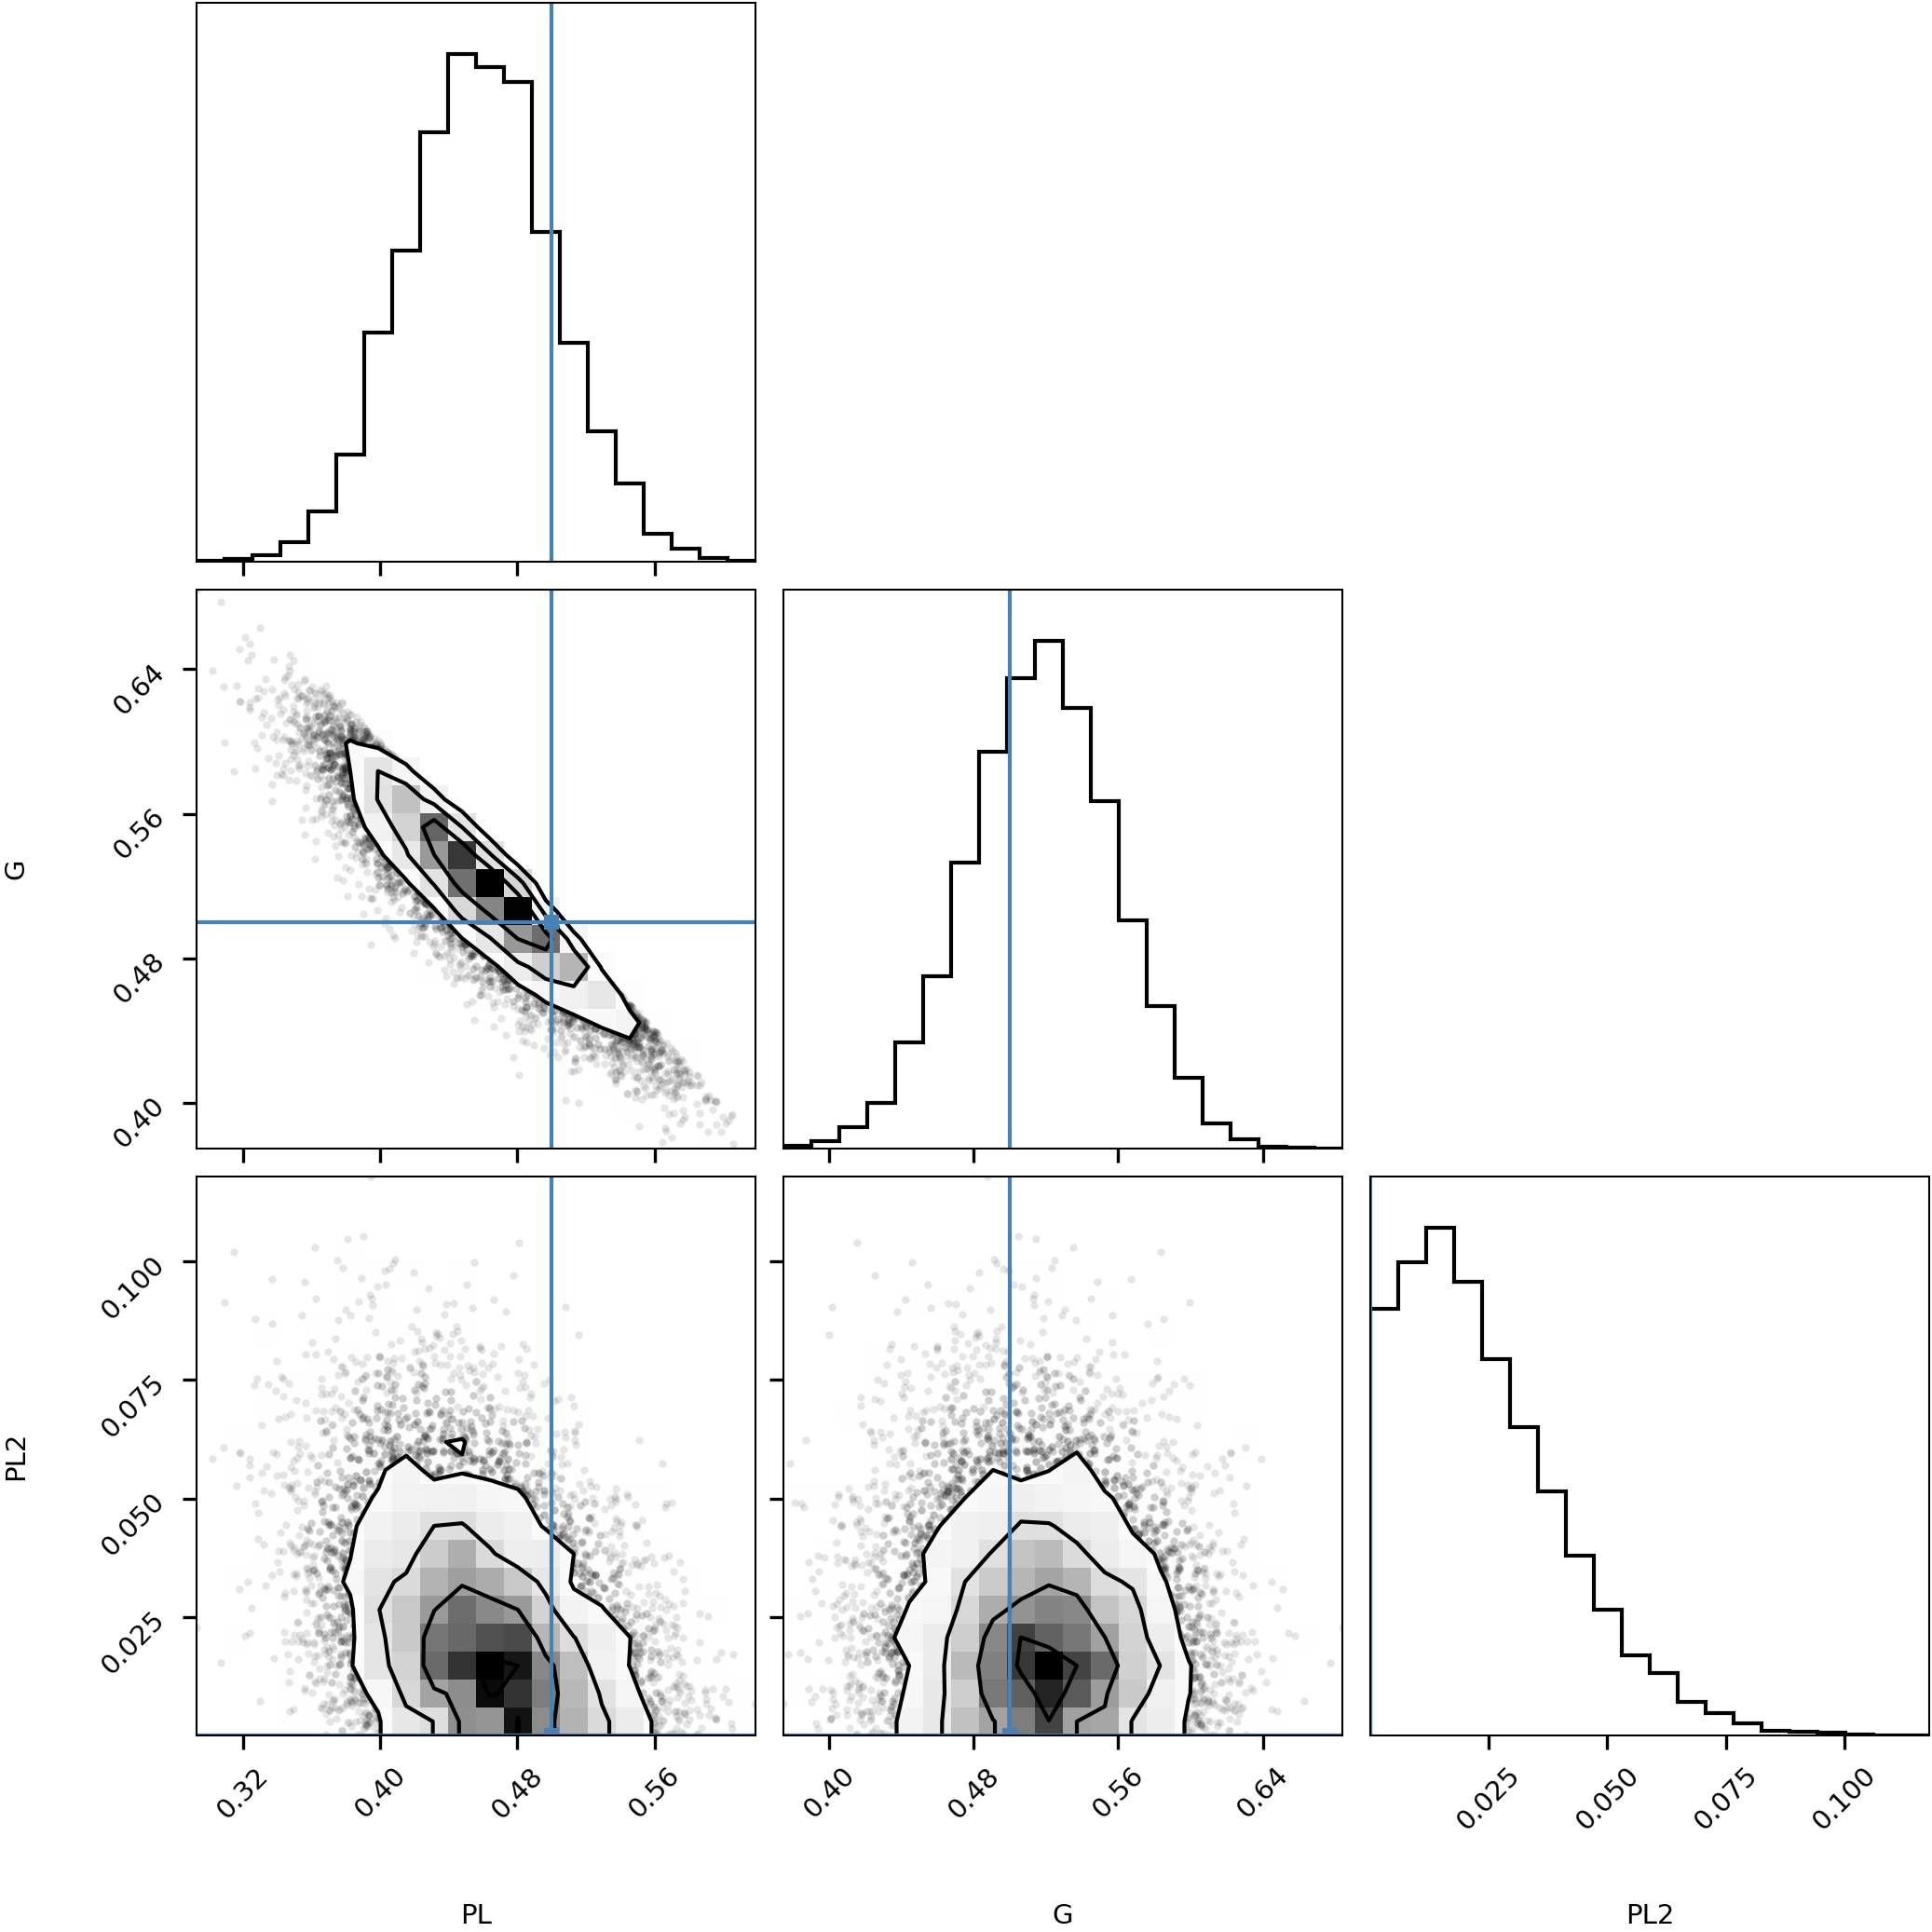

In [43]:
import corner
import bilby
### You can conver the angle samples to fractions using the following method
lamb=mixt.angles_to_fractions(res)
tt=np.column_stack([lamb[key] for key in lamb.keys()])
_=corner.corner(tt,truths=[.5,.5,0.],labels=[key for key in lamb.keys()])

# Bilby: Example with absolute mixtures

Below we show the example on the case that you want to sample with absolute coeffiecient. So here one is the true model, while the other two are just competing models.

In [44]:
Ngen=100000*5
true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':0.5})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(Ngen)
zs=true_redshift_distro.sample(Ngen)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_0=gwparents.synthetic_population.synthetic_population('True',Ntotal,popbin,prior_to_rem=np.ones(Ngen),prior_model=1.,Tobs=Tobs)


true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict={'mmin':5, 'mmax':100,'alpha':1.5,
                                                                         'beta':1.,'delta_m':5,'mu_g':35,'sigma_g':5,
                                                                         'lambda_peak':1.0})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(Ngen)
zs=true_redshift_distro.sample(Ngen)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_1=gwparents.synthetic_population.synthetic_population('Wrong1',Ntotal,popbin,prior_to_rem=np.ones(Ngen),prior_model=1.,Tobs=Tobs)



true_mass_distro=icarogw.priors.mass.mass_prior('BBH-powerlaw',hyper_params_dict={'mmin':5, 'mmax':40.,'alpha':-2.,
                                                                         'beta':1.})
true_redshift_distro=icarogw.priors.redshift.redshift_prior(icarogw.cosmologies.flatLCDM(zmax=1)
                                                            ,'madau',{'gamma':3.,'zp':2,'kappa':6})
m1s,m2s=true_mass_distro.sample(Ngen)
zs=true_redshift_distro.sample(Ngen)
Ntotal=np.trapz(true_redshift_distro.prob_astro(zlim),zlim)*Tobs*R0

popbin={'mass_1_source':{'values':m1s,'tex_label':r'$m_1 {\rm [M_{\odot}]}$','tex_var':r'm_1'},
        'mass_2_source': {'values':m2s,'tex_label':r'$m_2 {\rm [M_{\odot}}]$','tex_var':r'm_2'},
        'redshift': {'values':zs,'tex_label':r'$z$','tex_var':r'z'}}

pop_2=gwparents.synthetic_population.synthetic_population('Wrong2',Ntotal,popbin,prior_to_rem=np.ones(Ngen),prior_model=1.,Tobs=Tobs)



listofpop=gwparents.synthetic_population.list_of_populations([pop_0,pop_1,pop_2])

/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:161: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/priors/custom_math_priors.py:159: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)
/home/smastro/anaconda3/envs/gwparents/lib/python3.8/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/smastro/anaconda3/envs/gwparents/lib/py

In [45]:
mixt=gwparents.analyses.mixture_analyis(list_of_pos,listofpop,montecarlo_mode='posterior',scale_free=False)

In [46]:
## Note that now we are not passing the isotropic flag prior but priors on the absolute fractions.
## The sum of the fractions is not bounded to be one anymore we should get 1 for the true model and - for the rest.

res=mixt.run_bilby(pmode={'free':{'True':bilby.prior.Uniform(0.5,1.5,name='True'),
                              'Wrong1':bilby.prior.Uniform(0.,1.,name='Wrong1'),
                              'Wrong2':bilby.prior.Uniform(0.,0.5,name='Wrong2')}},
                   kernel_kwargs={'kernel_mode':'histogram','bins':{'mass_1_source':50,
                                                                        'mass_2_source':50,
                                                                        'redshift':50}},outdir='examples/',label='free')

Kernelizing populations: 3it [00:00, 21.40it/s]
Calculating match for Posterior #: 0it [00:00, ?it/s]/home/smastro/git_repositories/gwparents/gwparents/synthetic_population.py:572: RuntimeWarning: divide by zero encountered in log
  log_lij=_logsumexp(_np.log(self.kernel[list_of_index])-_np.log(prior_to_rem[idxfinal]))-_np.log(total_samples_j)
Calculating match for Posterior #: 226it [00:01, 130.25it/s]
17:11 bilby INFO    : Running for label 'free', output will be saved to 'examples/'
17:11 bilby INFO    : Search parameters:
17:11 bilby INFO    :   True = Uniform(minimum=0.5, maximum=1.5, name='True', latex_label='True', unit=None, boundary=None)
17:11 bilby INFO    :   Wrong1 = Uniform(minimum=0.0, maximum=1.0, name='Wrong1', latex_label='Wrong1', unit=None, boundary=None)
17:11 bilby INFO    :   Wrong2 = Uniform(minimum=0.0, maximum=0.5, name='Wrong2', latex_label='Wrong2', unit=None, boundary=None)
17:11 bilby INFO    : Single likelihood evaluation took 1.438e-04 s


Using prior mode  free
{'True': Uniform(minimum=0.5, maximum=1.5, name='True', latex_label='True', unit=None, boundary=None), 'Wrong1': Uniform(minimum=0.0, maximum=1.0, name='Wrong1', latex_label='Wrong1', unit=None, boundary=None), 'Wrong2': Uniform(minimum=0.0, maximum=0.5, name='Wrong2', latex_label='Wrong2', unit=None, boundary=None)}
0it [00:00, ?it/s]

17:11 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0e1c8d5790>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
17:11 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:11 bilby INFO    : Using dynesty version 1.0.1
17:11 bilby INFO    : Using the bilby-implemented rwalk sam

8874it [03:13, 32.15it/s, bound:1204 nc:151 ncall:8.5e+05 eff:1.0% logz=-493.38+/-0.10 dlogz:0.100>0.1] 

17:14 bilby INFO    : Written checkpoint file examples//free_resume.pickle
17:14 bilby INFO    : Writing 3449 current samples to examples//free_samples.dat


8875it [03:17, 44.98it/s, bound:1204 nc:  1 ncall:8.5e+05 eff:1.2% logz=-493.31+/-0.10 dlogz:0.000>0.1]



17:14 bilby INFO    : Sampling time: 0:03:12.813595
17:14 bilby INFO    : Summary of results:
nsamples: 9875
ln_noise_evidence:    nan
ln_evidence: -493.305 +/-  0.101
ln_bayes_factor:    nan +/-  0.101



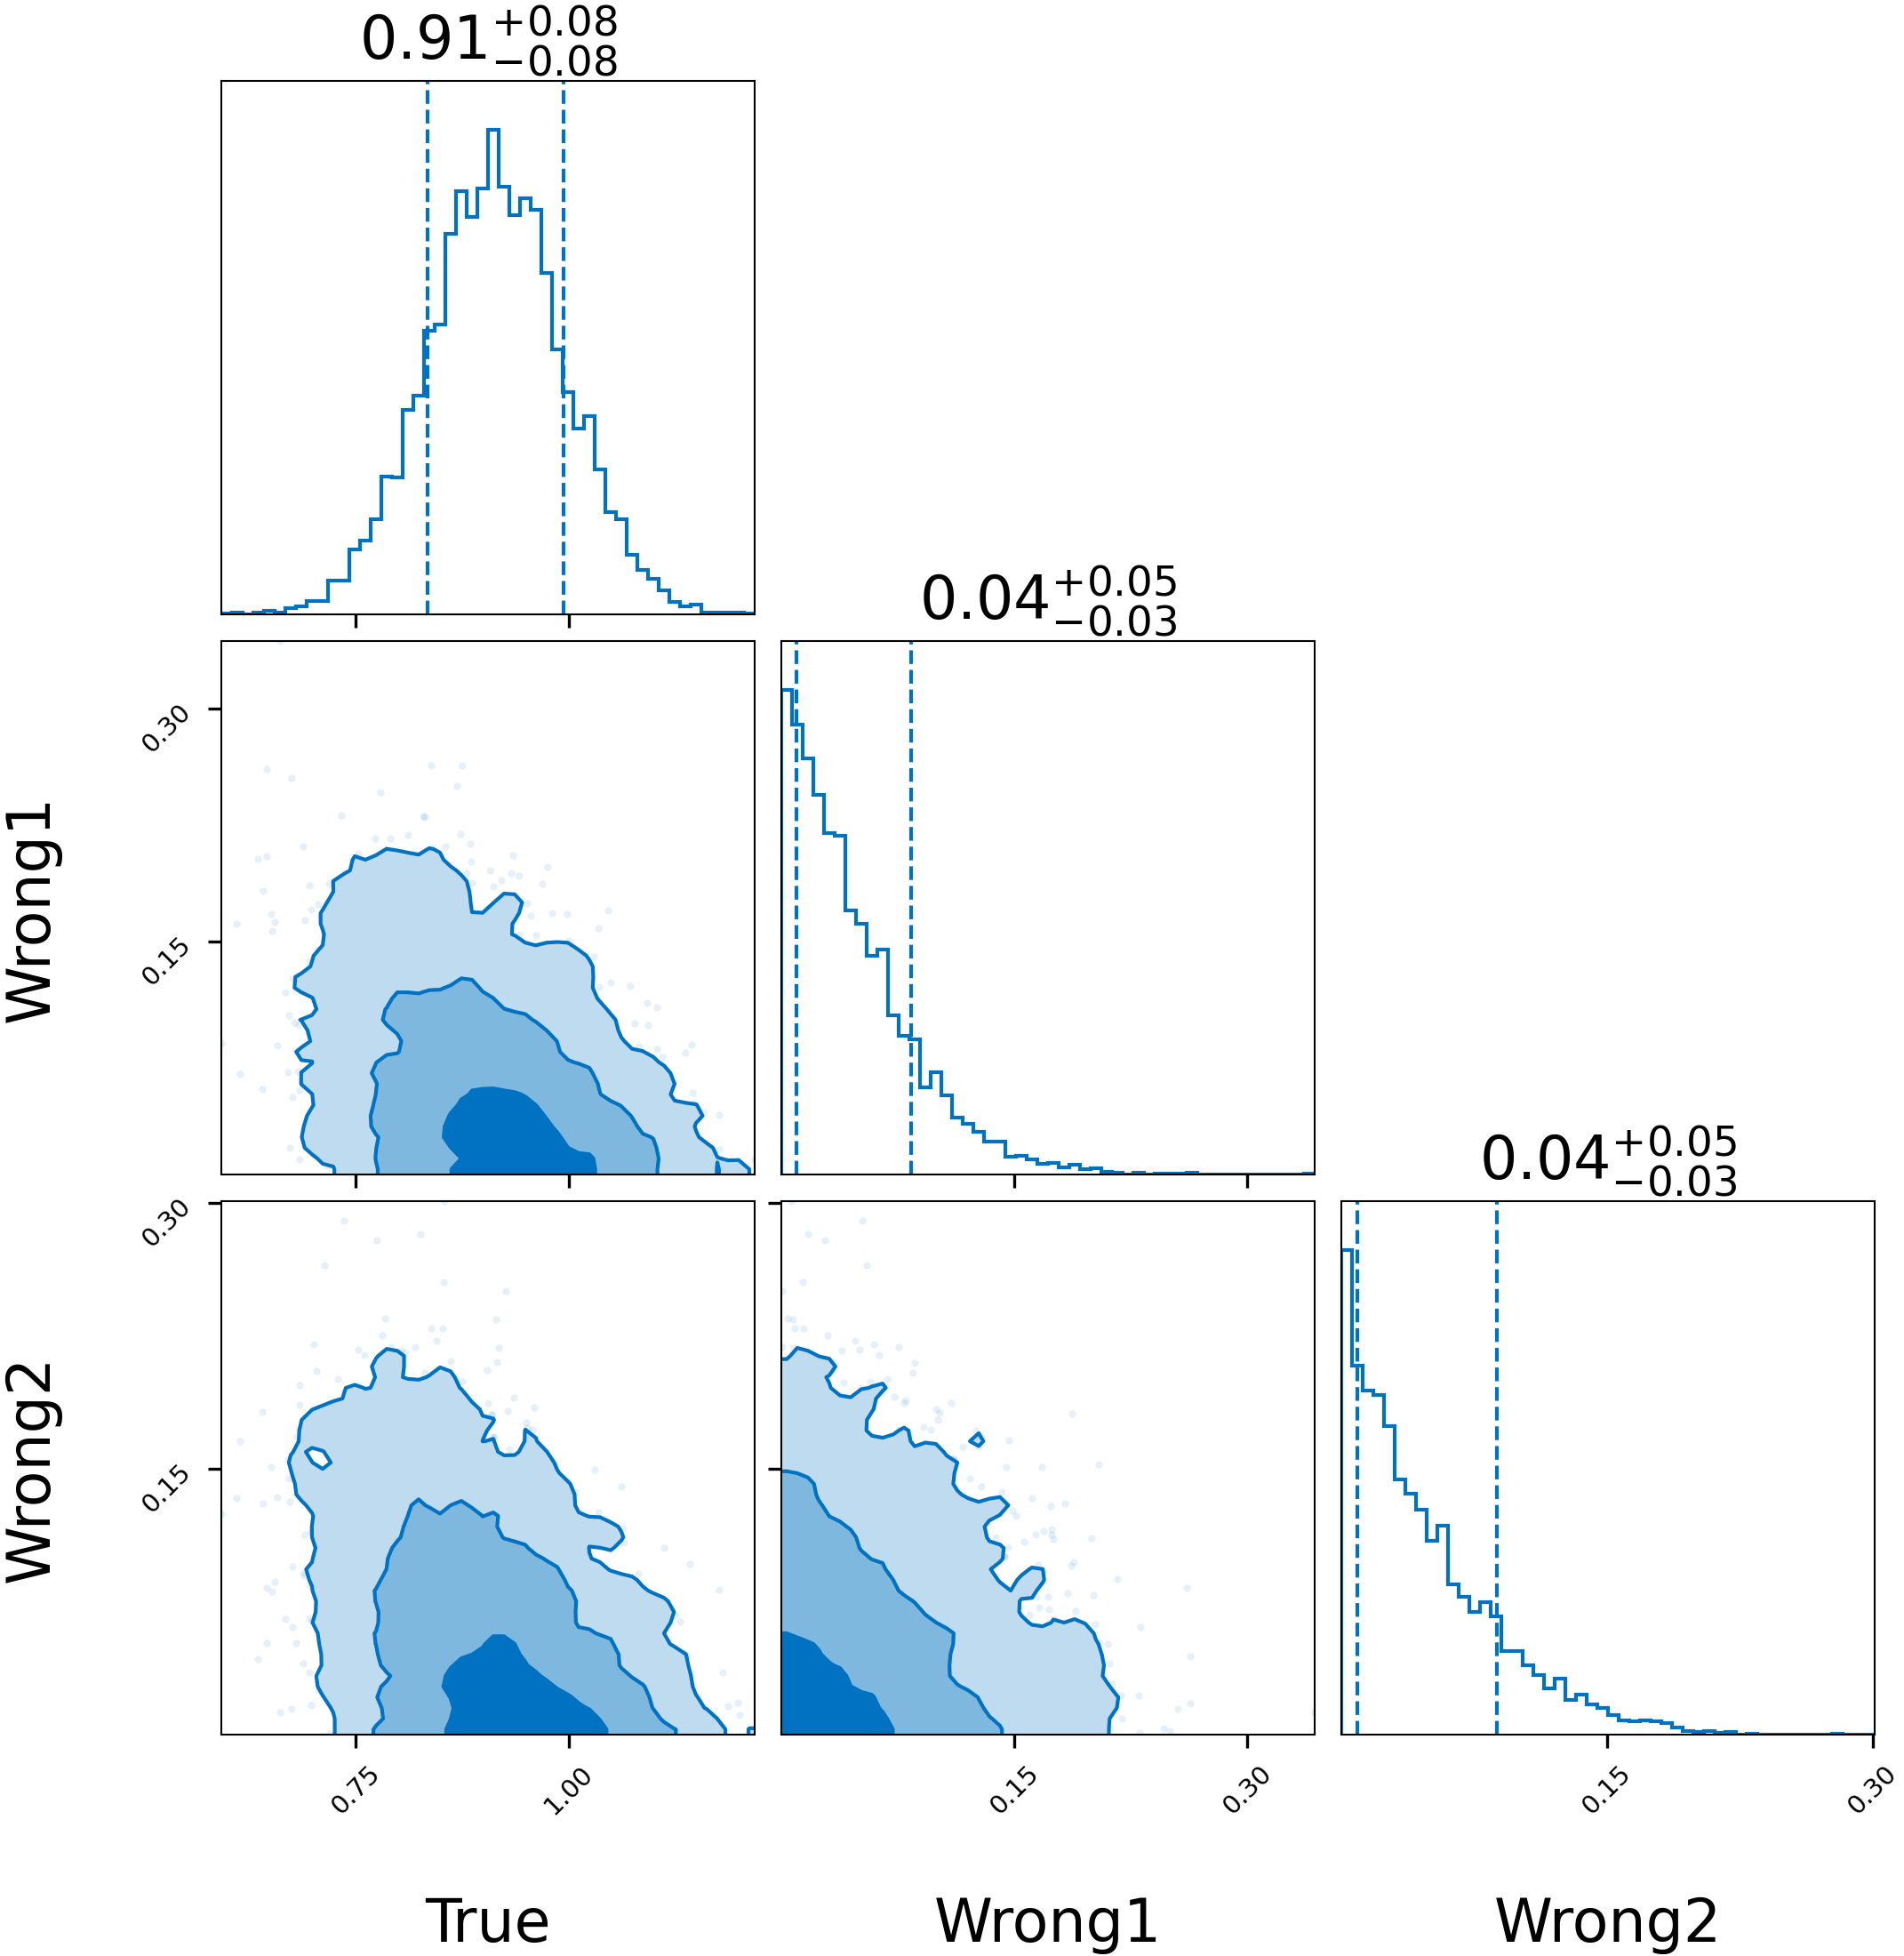

In [47]:
res.plot_corner()

In [48]:
!rm -r examples/*